# Drop features
 - Remove all first hour for all meastures : Tam | Done
  - drop the readmission state (all 0)
 - Drop apache_2_bodysystem
 - Patient who has more than 60 columns missing
 - Replce max with na witch mismatching problem
 -#### Drop columns rule for diastolic blood pressure measurement:

 `'d1_diasbp_invasive_max',
 'd1_diasbp_invasive_min',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min'`

 - Only keep one set of measurements: 
    1. how similarity of the measurements (highly correlated)
    2. Feature importants (regular invasive has higher importance)
    3. missing percentage (regular has lowest missing values)

- Keep 'd1_diasbp_max', 'd1_diasbp_min'


#### Drop columns rule for mbp measurement:

 `'d1_mbp_invasive_max',
 'd1_mbp_invasive_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',`

 - Only keep one set of measurements: 
    1. how similarity of the measurements (highly correlated with regular and noninvasive)
    2. Feature importants (regular invasive has higher importance)
    3. missing percentage (regular has lowest missing values)

- Keep 'd1_mbp_max', 'd1_mbp_min'

#### Drop columns rule for sysbp measurement:

`'d1_sysbp_invasive_max',
 'd1_sysbp_invasive_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',`

  - Only keep one set of measurements: 
    1. how similarity of the measurements (highly correlated with regular and noninvasive)
    2. Feature importants (regular invasive has higher importance)
    3. missing percentage (regular has lowest missing values)

- Keep 'd1_sysbp_max', 'd1_sysbp_min'

- For min max mismatching problem, we need to impute max values are na and then do imputation just as other missing values, based on our research max is all the same


# Impute
**Mice imputer (age, height, weight, ethinicty):**  (Confirmed)

    1. impute mean of age, height, weight
    2. regression for each of them and check the correlation and do the imputation
 - Impute BMI, after mice imputer

**ICU admit source, hospital admit source**  (Confirmed)
   - hospital admit source: 
     - groupby(icu_admit_source,hospital_admit_source).count()
     - impute the mode
   - icu_admit source
     - take the most frequent one
   - Missing together (Still deciding)
     - impute by most frequent
     - or impute by top 4 randomly based on the distribution

**disbp, sysbp** (Confirmed)

    - only keep d1_diasbp_max', 'd1_diasbp_min','d1_sysbp_max', 'd1_sysbp_min'
    - impute mismatch  max values as na
    - first define a category based on low, normal, pre hypertension, high stage 1, high stage 2 (based on the graph)
    - check the how min fall in to each category, and impute the max

**temperature: median to impute temperatue**  (Confirmed)

**mbp**
   -d1_mbp_max', 'd1_mbp_min'
   - impute mismatch  max values as na
   - After impute disbp, sysbp,

 - resperate, and mbp (Tam)

**lab category**
   - lab mice impute, with apache_3j_bodysystem
**apache score**
   - mice impute, with apache_3j_bodysytem
   
**Futher analysis**
  - gcs_ unable_apache == 1 check for gcs_eyes_apache, gcs_moter_apache,
  - intubated_apache ==1 check for lab blood gas cateory, paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache


Assumption: 
- data within 1st hour correlates to data collected within 24 hours 
- we dont want to bias the data by imputed features with 60 or 70% of missing values. Hence, data collected within 1 hour, we drop

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
from plotly import tools
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline

import datetime, warnings, scipy 
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from collections import Counter
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
# mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"


# pickle
import pickle

import missingno as msno

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set standard parameters
pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.max_columns', 1000)
np.random.seed(566)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', -1)

In [0]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
!ls "/content/drive/My Drive"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
'Colab Notebooks'
'data mining final project'
'Data Mining Principle final project'
 DEP_FinalProject
 DMP_loan_project
 Healthcare
'health project 3'
'job application'
'Latent Dirichlet Allocation.gslides'
'leadership_assignment 4_note.gdoc'
'NLP note.gdoc'
 Progressive_Insurance_1.gslides
'Progressive Insurance Business Case - Question Brainstorm.gdoc'
'renew DL'
'uchicago academic fall 2019'
'uchicago admission'
'Video script'


In [0]:
df = pd.read_csv('/content/drive/My Drive/Healthcare/Data/df_clean.csv', low_memory = False)
dictionary = pd.read_csv('/content/drive/My Drive/Healthcare/Data/WiDS Datathon 2020 Dictionary.csv')

In [0]:
df.shape

(91713, 122)

In [0]:
df.isna()

# demographic

### age: check with gender and ethnicity

In [0]:
df_deAP=df[df.columns[:46]]
df_deAP.isnull().sum()*100/df_deAP.shape[0]

Unnamed: 0              0.0 
encounter_id            0.0 
hospital_id             0.0 
patient_id              0.0 
hospital_death          0.0 
age                     4.6 
bmi                     3.7 
elective_surgery        0.0 
ethnicity               1.5 
gender                  0.0 
height                  1.5 
hospital_admit_source   23.3
icu_admit_source        0.1 
icu_id                  0.0 
icu_stay_type           0.0 
icu_type                0.0 
pre_icu_los_days        0.0 
weight                  3.0 
albumin_apache          59.3
apache_2_diagnosis      1.8 
apache_3j_diagnosis     1.2 
apache_post_operative   0.0 
arf_apache              0.8 
bilirubin_apache        63.4
bun_apache              21.0
creatinine_apache       20.6
fio2_apache             77.3
gcs_eyes_apache         2.1 
gcs_motor_apache        2.1 
gcs_unable_apache       1.1 
gcs_verbal_apache       2.1 
glucose_apache          12.0
heart_rate_apache       1.0 
hematocrit_apache       21.7
intubated_apac

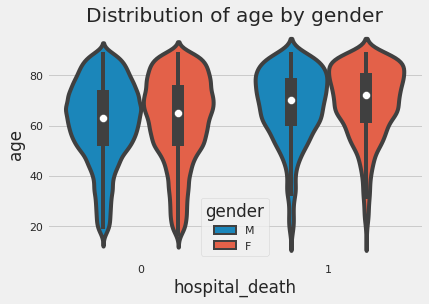

In [0]:
sns.violinplot(x="hospital_death", y="age", hue="gender", data=df)
plt.title("Distribution of age by gender")
plt.show()

In [0]:
stats1 =df_deAP.groupby(['hospital_death','gender']).agg({'age':['mean','median']}).reset_index()
stats1

hospital_death gender  age       
                        mean median
0  0              F     62.2 65.0  
1  0              M     61.4 63.0  
2  1              F     69.3 72.0  
3  1              M     67.8 70.0

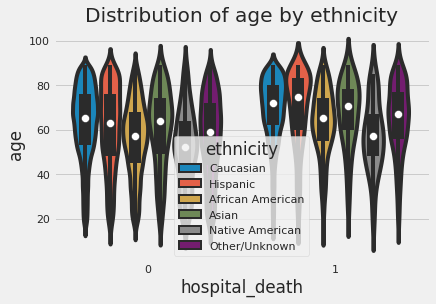

In [0]:
sns.violinplot(x="hospital_death",y="age", hue="ethnicity",data=df)
plt.title("Distribution of age by ethnicity")
plt.show()

In [0]:
df[df["age"].isnull()].ethnicity.isnull().sum()

55

In [0]:
stats2 =df_deAP.groupby(['hospital_death','ethnicity']).agg({'age':['mean','median','min','max']}).reset_index().sort_values('ethnicity')
stats2

hospital_death         ethnicity  age                 
                                    mean median  min  max
0   0              African American 55.8 57.0   16.0 89.0
6   1              African American 63.4 65.0   16.0 89.0
1   0              Asian            60.7 64.0   17.0 89.0
7   1              Asian            67.5 70.5   24.0 89.0
2   0              Caucasian        63.1 65.0   16.0 89.0
8   1              Caucasian        69.4 72.0   16.0 89.0
3   0              Hispanic         60.8 63.0   16.0 89.0
9   1              Hispanic         69.9 74.5   19.0 89.0
4   0              Native American  51.2 52.0   16.0 88.0
10  1              Native American  57.3 57.0   19.0 85.0
5   0              Other/Unknown    57.3 59.0   16.0 89.0
11  1              Other/Unknown    65.1 67.0   19.0 89.0

### bmi: check with weight，height, gender, ethnicity, surgery
- bmi = weight/[height^2]

In [0]:
#missing together
print('There are {} of bmi value is missing.'.format(df.bmi.isnull().sum()))
print('There are {} of weight value is missing.'.format(df.weight.isnull().sum()))
print('There are {} of height value is missing.'.format(df.height.isnull().sum()))
print('There are {} of bmi and weight value are missing together.'.format(df[df.bmi.isnull()].weight.isnull().sum()))
print('There are {} of bmi and height value are missing together.'.format(df[df.bmi.isnull()].height.isnull().sum()))
print('There are {} of three variables missing together.'.format(df[(df.bmi.isnull())&(df.weight.isnull())&(df.height.isnull())].shape[0]))

There are 3429 of bmi value is missing.
There are 2720 of weight value is missing.
There are 1334 of height value is missing.
There are 2720 of bmi and weight value are missing together.
There are 1334 of bmi and height value are missing together.
There are 625 of three variables missing together.


In [0]:
df[(df.weight.isnull()==False)&(df.height.isnull())&(df.bmi.isnull())].shape[0]

709

In [0]:
df[(df.weight.isnull())&(df.height.isnull()==False)&(df.bmi.isnull())].shape[0]

2095

In [0]:
df[(df.weight.isnull())&(df.height.isnull())&(df.bmi.isnull()==False)].shape[0]

0

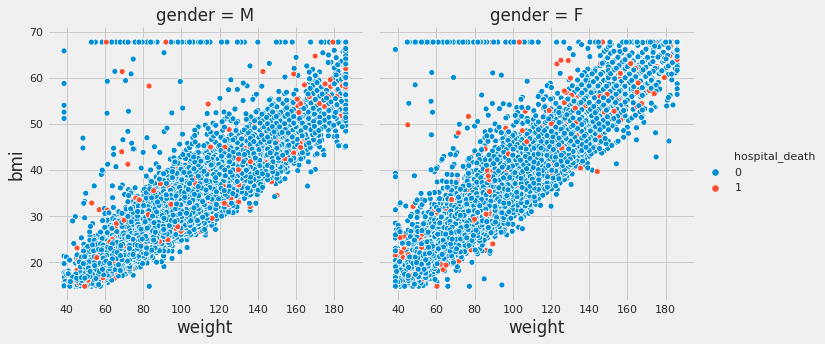

In [0]:
sns.relplot(x="weight", y="bmi", col="gender", hue="hospital_death", kind="scatter",data=df)

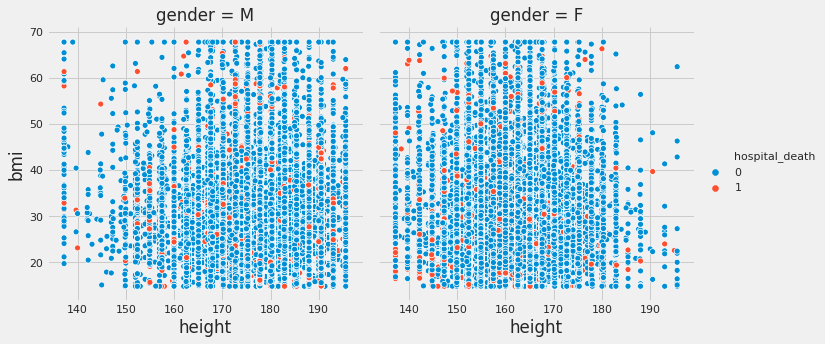

In [0]:
sns.relplot(x="height", y="bmi", col="gender", hue="hospital_death", kind="scatter", data=df)

Text(0.5, 1.0, 'Distribution of bmi by gender')

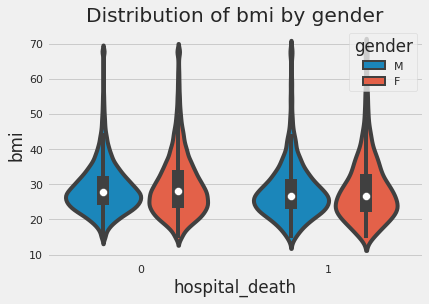

In [0]:
sns.violinplot(y="bmi", x="hospital_death", hue="gender",data=df)
plt.title("Distribution of bmi by gender")

In [0]:
stats3 =df_deAP.groupby(['hospital_death','gender']).agg({'bmi':['mean','median','min','max']}).reset_index().sort_values('gender')
stats3

hospital_death gender  bmi                 
                        mean median  min  max
0  0              F     29.7 27.9   14.8 67.8
2  1              F     28.6 26.6   14.8 67.8
1  0              M     28.9 27.7   14.8 67.8
3  1              M     28.1 26.6   14.8 67.8

Text(0.5, 1.0, 'Distribution of bmi by ethnicity')

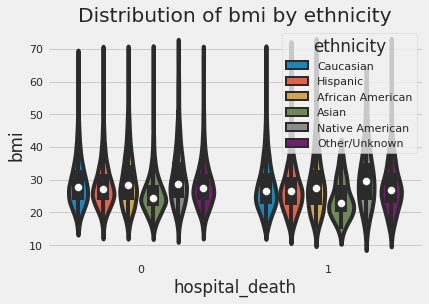

In [0]:
sns.violinplot(y="bmi",x="hospital_death", hue="ethnicity",data=df)
plt.title("Distribution of bmi by ethnicity")

In [0]:
stats3 =df_deAP.groupby(['hospital_death','ethnicity']).agg({'bmi':['mean','median','min','max']}).reset_index().sort_values('ethnicity')
stats3

hospital_death         ethnicity  bmi                 
                                    mean median  min  max
0   0              African American 30.1 28.3   14.8 67.8
6   1              African American 29.0 27.3   14.8 67.8
1   0              Asian            25.6 24.5   14.8 67.8
7   1              Asian            24.0 22.8   14.8 37.8
2   0              Caucasian        29.3 27.8   14.8 67.8
8   1              Caucasian        28.4 26.6   14.8 67.8
3   0              Hispanic         28.5 27.2   14.8 67.8
9   1              Hispanic         27.1 26.5   14.8 67.8
4   0              Native American  31.0 28.7   15.9 67.8
10  1              Native American  30.3 29.5   15.9 56.6
5   0              Other/Unknown    28.7 27.4   14.8 67.8
11  1              Other/Unknown    28.3 26.8   14.8 67.8

Text(0.5, 1.0, 'Distribution of bmi by elective_surgery')

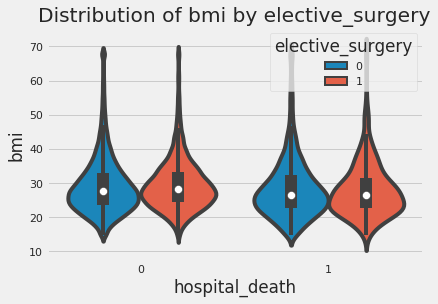

In [0]:
sns.violinplot(y="bmi", x="hospital_death", hue="elective_surgery",data=df)
plt.title("Distribution of bmi by elective_surgery")

### ethnicity: mode

In [0]:
from collections import Counter
Counter(df.ethnicity)

Counter({'African American': 9547,
         'Asian': 1129,
         'Caucasian': 70684,
         'Hispanic': 3796,
         'Native American': 788,
         'Other/Unknown': 4374,
         nan: 1395})

### height: check with gender and ethnicity

In [0]:
df.gender.isnull().sum()

25

In [0]:
df.height.isnull().sum()

1334

In [0]:
#missing together: 6 missing both gender and height
#df[df.gender.isnull()].height.isnull().sum()
df[df.height.isnull()].gender.isnull().sum()

6

In [0]:
df[(df.height.isnull())&(df.gender.isnull())]

Unnamed: 0  encounter_id  hospital_id  patient_id  hospital_death  age  bmi  elective_surgery      ethnicity gender  height hospital_admit_source      icu_admit_source  icu_id icu_stay_type      icu_type  pre_icu_los_days  weight  albumin_apache  apache_2_diagnosis  apache_3j_diagnosis  apache_post_operative  arf_apache  bilirubin_apache  bun_apache  creatinine_apache  fio2_apache  gcs_eyes_apache  gcs_motor_apache  gcs_unable_apache  gcs_verbal_apache  glucose_apache  heart_rate_apache  hematocrit_apache  intubated_apache  map_apache  paco2_apache  paco2_for_ph_apache  pao2_apache  ph_apache  resprate_apache  sodium_apache  temp_apache  urineoutput_apache  ventilated_apache  wbc_apache  d1_diasbp_invasive_max  d1_diasbp_invasive_min  d1_diasbp_max  d1_diasbp_min  d1_diasbp_noninvasive_max  d1_diasbp_noninvasive_min  d1_heartrate_max  d1_heartrate_min  d1_mbp_invasive_max  d1_mbp_invasive_min  d1_mbp_max  d1_mbp_min  d1_mbp_noninvasive_max  d1_mbp_noninvasive_min  \
1177   1177        69281         83           72373       1              nan  nan   0                 NaN            NaN   nan      Emergency Department  Accident & Emergency  95      admit         Med-Surg ICU 0.0               49.9    nan             114.0               102.0                 0                     0.0         nan               11.0        0.9                1.0          1.0              1.0               0.0                1.0                580.0           135.0              26.5               1.0               40.0        43.0          43.0                 230.0        7.0        4.0              139.0          34.6         nan                 1.0                18.8        nan                     nan                     158.0          25.0           158.0                      25.0                       145.0             0.0               nan                  nan                  89.0        35.0        89.0                    35.0                      
12417  12417       109859        177          35890       1              81.0 nan   0                 NaN            NaN   nan      Emergency Department  Accident & Emergency  248     admit         Med-Surg ICU 0.0               nan     nan             304.0               312.0                 0                     0.0         nan               nan         nan                nan          2.0              4.0               0.0                4.0                nan             112.0              nan                0.0               40.0        nan           nan                  nan          nan        38.0             nan            nan          nan                 0.0                nan         nan                     nan                     60.0           19.0           60.0                       19.0                       112.0             0.0               nan                  nan                  67.0        25.0        67.0                    25.0                      
43103  43103       48429         100          2117        1              nan  nan   0                 Other/Unknown  NaN   nan      Emergency Department  Accident & Emergency  490     admit         Med-Surg ICU 0.0               78.0    nan             119.0               601.0                 0                     0.0         nan               nan         nan                nan          1.0              1.0               0.0                1.0                nan             31.0               nan                0.0               40.0        nan           nan                  nan          nan        26.0             nan            35.2         nan                 1.0                nan         nan                     nan                     49.0           29.0           49.0                       29.0                       76.0              31.0              nan                  nan                  65.0        40.0        65.0                    40.0                      
43725  43725       3283          100          3779     

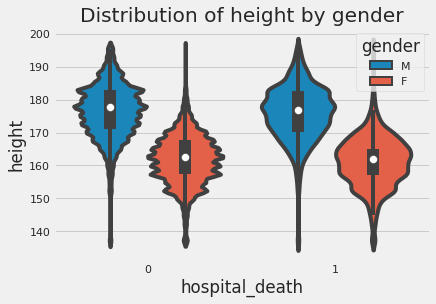

In [0]:
sns.violinplot(x="hospital_death", y="height", hue="gender", data=df)
plt.title("Distribution of height by gender")
plt.show()

In [0]:
stats4 =df_deAP.groupby(['hospital_death','gender']).agg({'height':['mean','median','min','max']}).reset_index().sort_values('gender')
stats4

hospital_death gender height                   
                          mean median   min   max
0  0              F     161.7  162.6  137.2 195.6
2  1              F     161.1  162.0  137.2 195.6
1  0              M     176.5  177.8  137.2 195.6
3  1              M     176.0  177.0  137.2 195.6

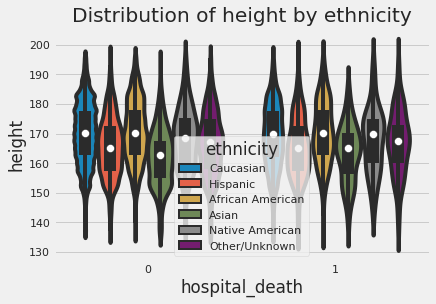

In [0]:
sns.violinplot(x="hospital_death", y="height", hue="ethnicity", data=df)
plt.title("Distribution of height by ethnicity")
plt.show()

In [0]:
stats5 =df_deAP.groupby(['hospital_death','ethnicity']).agg({'height':['mean','median','min','max']}).reset_index().sort_values('ethnicity')
stats5

hospital_death         ethnicity height                   
                                      mean median   min   max
0   0              African American 170.7  170.2  137.2 195.6
6   1              African American 170.3  170.1  137.2 195.6
1   0              Asian            162.0  162.6  137.2 193.0
7   1              Asian            163.6  165.0  139.7 184.9
2   0              Caucasian        170.1  170.2  137.2 195.6
8   1              Caucasian        169.2  170.0  137.2 195.6
3   0              Hispanic         165.7  165.1  137.2 195.6
9   1              Hispanic         165.3  165.1  137.2 195.0
4   0              Native American  168.5  168.5  137.2 195.6
10  1              Native American  167.6  170.0  144.8 193.0
5   0              Other/Unknown    166.6  167.0  137.2 195.6
11  1              Other/Unknown    167.1  167.6  137.2 195.5

### hospital_admit_source: check with icu_admit_source

In [0]:
#missing together
print(df[df.hospital_admit_source.isnull()].icu_admit_source.isnull().sum())
print(df.hospital_admit_source.isnull().sum())
print(df.icu_admit_source.isnull().sum())

111
21409
112


In [0]:
Counter(df.hospital_admit_source)

Counter({'Acute Care/Floor': 1910,
         'Chest Pain Center': 134,
         'Direct Admit': 6441,
         'Emergency Department': 36962,
         'Floor': 8055,
         'ICU': 35,
         'ICU to SDU': 45,
         'Observation': 10,
         'Operating Room': 9787,
         'Other': 7,
         'Other Hospital': 1641,
         'Other ICU': 233,
         'PACU': 1017,
         'Recovery Room': 2896,
         'Step-Down Unit (SDU)': 1131,
         nan: 21409})

In [0]:
Counter(df.icu_admit_source)

Counter({'Accident & Emergency': 54060,
         'Floor': 15611,
         'Operating Room / Recovery': 18713,
         'Other Hospital': 2358,
         'Other ICU': 859,
         nan: 112})

In [0]:
df.groupby(["icu_admit_source","hospital_admit_source"])['patient_id'].count()

icu_admit_source           hospital_admit_source
Accident & Emergency       Acute Care/Floor         30   
                           Chest Pain Center        4    
                           Direct Admit             5749 
                           Emergency Department     35193
                           Floor                    108  
                           ICU                      8    
                           Observation              1    
                           Operating Room           141  
                           Other                    1    
                           Other Hospital           71   
                           Other ICU                4    
                           PACU                     18   
                           Recovery Room            51   
                           Step-Down Unit (SDU)     4    
Floor                      Acute Care/Floor         1722 
                           Chest Pain Center        122  
                       

### icu_admit_source: mode

### weight: check with bmi, gender, ethnicity

In [0]:
#missing together
print(df.bmi.isnull().sum())
print(df.weight.isnull().sum())
print(df[df.bmi.isnull()].weight.isnull().sum())
# the bmi for missing weight is missing too

3429
2720
2720


Text(0.5, 1.0, 'Distribution of weight by gender')

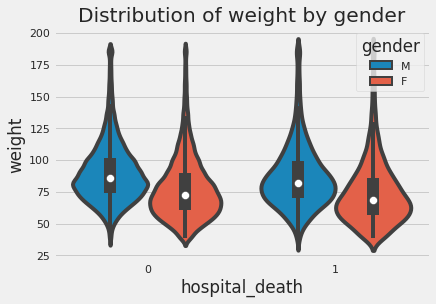

In [0]:
sns.violinplot(x="hospital_death", y="weight", hue="gender", data=df)
plt.title("Distribution of weight by gender")

Text(0.5, 1.0, 'Distribution of weight by ethnicity')

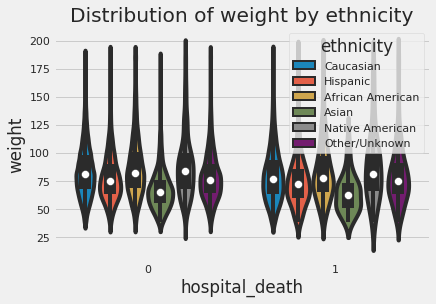

In [0]:
sns.violinplot(x="hospital_death", y="weight", hue="ethnicity", data=df)
plt.title("Distribution of weight by ethnicity")

### Death rate for different categories

In [0]:
disc_variable=["elective_surgery", 'ethnicity',
 'gender', 'hospital_admit_source',
 'icu_admit_source', 'icu_stay_type',
 'icu_type', 'apache_post_operative', 'arf_apache',
  'gcs_unable_apache', 'intubated_apache','ventilated_apache']

In [0]:
for i in disc_variable:
  stats1 =df.groupby([i]).agg({'hospital_death':['sum','count']}).reset_index()
  stats1['death_rate']=np.round(stats1['hospital_death']['sum']/stats1['hospital_death']['count']*100,2)
  stats1.sort_values('death_rate',ascending = False)
  print("-"*50)
  print(stats1)

--------------------------------------------------
  elective_surgery hospital_death        death_rate
                              sum  count           
0  0                7394           74862 9.9       
1  1                521            16851 3.1       
--------------------------------------------------
          ethnicity hospital_death        death_rate
                               sum  count           
0  African American  750            9547  7.9       
1  Asian             93             1129  8.2       
2  Caucasian         6168           70684 8.7       
3  Hispanic          376            3796  9.9       
4  Native American   70             788   8.9       
5  Other/Unknown     353            4374  8.1       
--------------------------------------------------
  gender hospital_death        death_rate
                    sum  count           
0  F      3731           42219 8.8       
1  M      4176           49469 8.4       
-----------------------------------------------

# apache check with bodysystems

In [0]:
from collections import Counter
# apache_3j_bodysystem, apache_2_bodysystem
df.apache_2_bodysystem.replace("Undefined diagnoses", "Undefined Diagnoses", inplace=True)
Counter(df.apache_2_bodysystem)

Counter({'Cardiovascular': 38816,
         'Gastrointestinal': 9026,
         'Haematologic': 638,
         'Metabolic': 7650,
         'Neurologic': 11896,
         'Renal/Genitourinary': 2460,
         'Respiratory': 11609,
         'Trauma': 3842,
         'Undefined Diagnoses': 4114,
         nan: 1662})

In [0]:
Counter(df.apache_3j_bodysystem)

Counter({'Cardiovascular': 29999,
         'Gastrointestinal': 9026,
         'Genitourinary': 2172,
         'Gynecological': 313,
         'Hematological': 638,
         'Metabolic': 7650,
         'Musculoskeletal/Skin': 1166,
         'Neurological': 11896,
         'Respiratory': 11609,
         'Sepsis': 11740,
         'Trauma': 3842,
         nan: 1662})

### albumin_apache: check with apache_3j_bodysystem, apache_2_bodysystem, hospital_admit_source, icu_admit_source

albumin_apache missing:  54379
apache_3j_diagnosis missing:  1662
missing together:  1422
------------------------------------------------------------


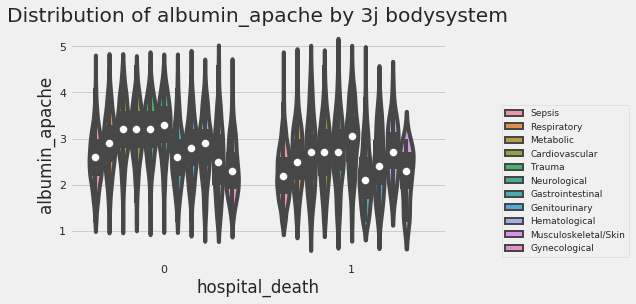

In [0]:
print("albumin_apache missing: ",df.albumin_apache.isnull().sum())
print("apache_3j_diagnosis missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.albumin_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="hospital_death", y="albumin_apache", hue="apache_3j_bodysystem", data=df)
plt.title("Distribution of albumin_apache by 3j bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)

albumin_apache missing:  54379
apache_3j_diagnosis missing:  1662
missing together:  1422
------------------------------------------------------------


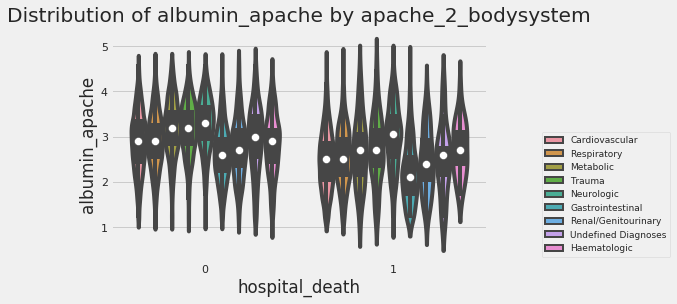

In [0]:
print("albumin_apache missing: ",df.albumin_apache.isnull().sum())
print("apache_3j_diagnosis missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.albumin_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="hospital_death", y="albumin_apache", hue="apache_2_bodysystem", data=df)
plt.title("Distribution of albumin_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)

albumin_apache missing:  54379
apache_3j_diagnosis missing:  21409
missing together:  11762
------------------------------------------------------------


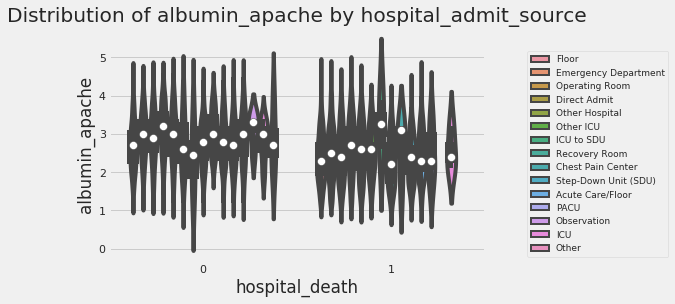

In [0]:
print("albumin_apache missing: ",df.albumin_apache.isnull().sum())
print("apache_3j_diagnosis missing: ", df.hospital_admit_source.isnull().sum())
print("missing together: ", df[df.albumin_apache.isnull()].hospital_admit_source.isnull().sum())
print("-"*60)
sns.violinplot(x="hospital_death", y="albumin_apache", hue="hospital_admit_source", data=df)
plt.title("Distribution of albumin_apache by hospital_admit_source")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)

albumin_apache missing:  54379
apache_3j_diagnosis missing:  112
missing together:  84
------------------------------------------------------------


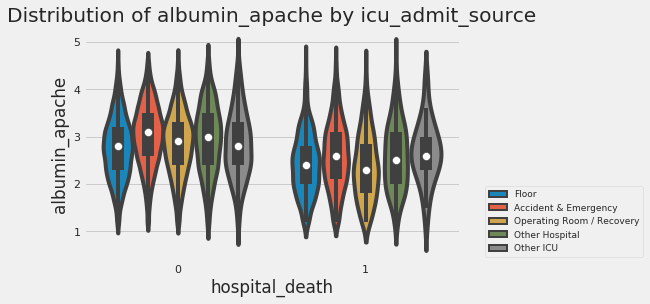

In [0]:
print("albumin_apache missing: ",df.albumin_apache.isnull().sum())
print("apache_3j_diagnosis missing: ", df.icu_admit_source.isnull().sum())
print("missing together: ", df[df.albumin_apache.isnull()].icu_admit_source.isnull().sum())
print("-"*60)
sns.violinplot(x="hospital_death", y="albumin_apache", hue="icu_admit_source", data=df)
plt.title("Distribution of albumin_apache by icu_admit_source")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)

### arf_apache: check with creatinine_apache and two bodysystems

arf_apache missing:  715
apache 3j bodysystem missing:  1662
missing together:  715
------------------------------------------------------------


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

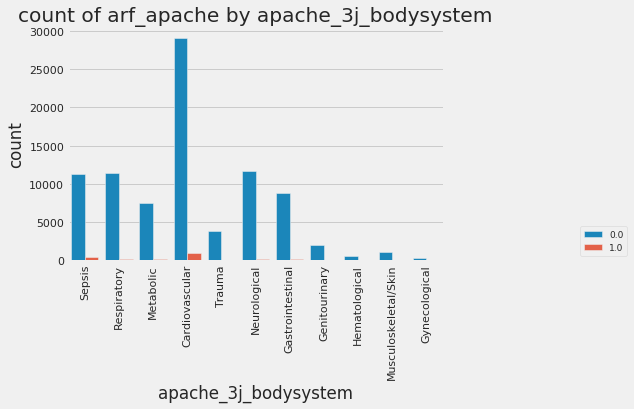

In [0]:
print("arf_apache missing: ", df.arf_apache.isnull().sum())
print("apache 3j bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.arf_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
#sns.barplot(x="apache_3j_bodysystem", hue="hospital_death", y="apache_3j_bodysystem",data=df)
sns.countplot(x="apache_3j_bodysystem", hue="arf_apache", data=df)
plt.title("count of arf_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

arf_apache missing:  715
apache 2 bodysystem missing:  1662
missing together:  715
------------------------------------------------------------


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

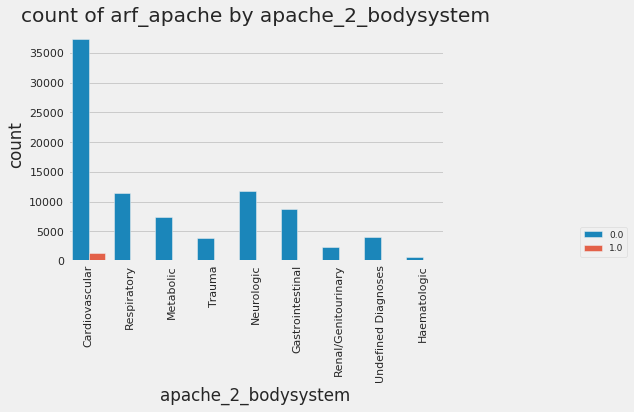

In [0]:
print("arf_apache missing: ", df.arf_apache.isnull().sum())
print("apache 2 bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.arf_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
#sns.barplot(x="apache_3j_bodysystem", hue="hospital_death", y="apache_3j_bodysystem",data=df)
sns.countplot(x="apache_2_bodysystem", hue="arf_apache", data=df)
plt.title("count of arf_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

arf_apache missing:  715
creatinine_apache missing:  18853
missing together:  715
------------------------------------------------------------


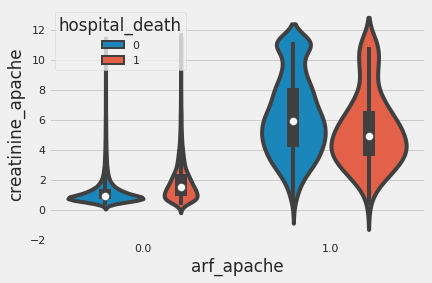

In [0]:
print("arf_apache missing: ", df.arf_apache.isnull().sum())
print("creatinine_apache missing: ", df.creatinine_apache.isnull().sum())
print("missing together: ", df[df.arf_apache.isnull()].creatinine_apache.isnull().sum())
print("-"*60)
sns.violinplot(x="arf_apache", y="creatinine_apache", hue="hospital_death", data=df)

### bilirubin_apache: check with two bodysystems

bilirubin_apache missing:  58134
apache_3j_bodysystem missing:  1662
missing together:  1454
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

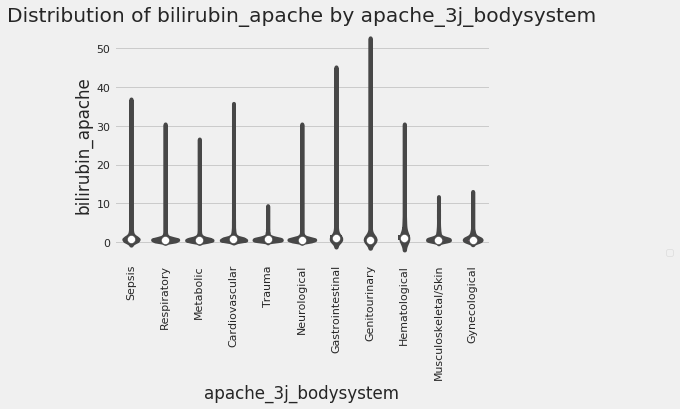

In [0]:
print("bilirubin_apache missing: ", df.bilirubin_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.bilirubin_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="bilirubin_apache", data=df)
plt.title("Distribution of bilirubin_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

bilirubin_apache missing:  58134
apache_2_bodysystem missing:  1662
missing together:  1454
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

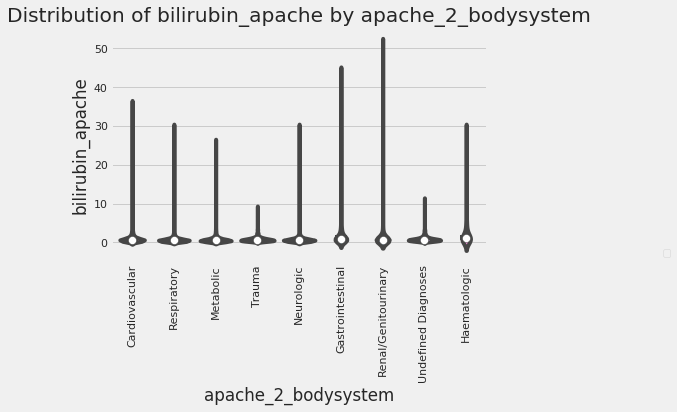

In [0]:
print("bilirubin_apache missing: ", df.bilirubin_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.bilirubin_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="bilirubin_apache", data=df)
plt.title("Distribution of bilirubin_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### bun_apache: check with two bodysystems

bun_apache missing:  19262
apache_3j_bodysystem missing:  1662
missing together:  1056
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

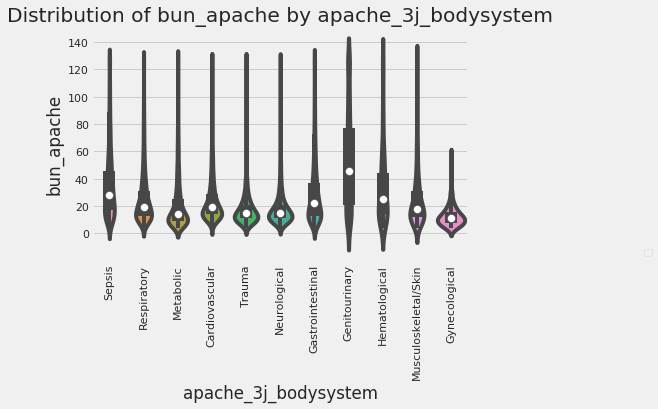

In [0]:
print("bun_apache missing: ", df.bun_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.bun_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="bun_apache", data=df)
plt.title("Distribution of bun_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

bun_apache missing:  19262
apache_2_bodysystem missing:  1662
missing together:  1056
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

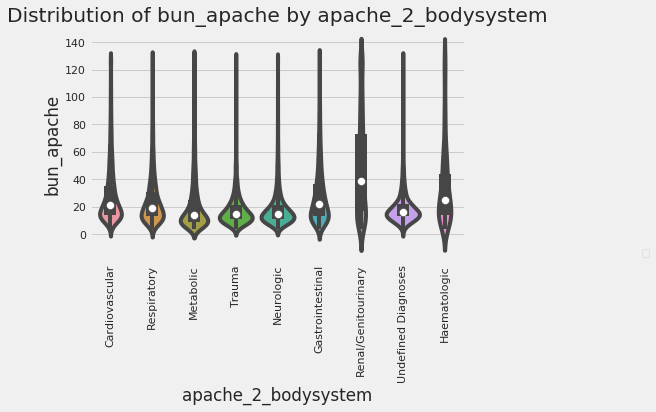

In [0]:
print("bun_apache missing: ", df.bun_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.bun_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="bun_apache", data=df)
plt.title("Distribution of bun_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### creatinine_apache: check with two bodysystems

creatinine_apache missing:  18853
apache_3j_bodysystem missing:  1662
missing together:  1051
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

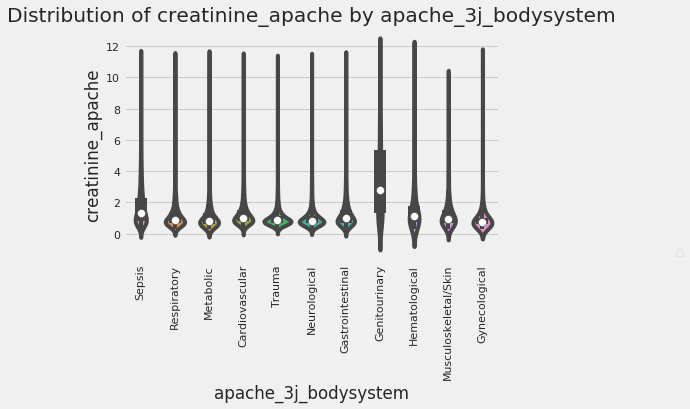

In [0]:
print("creatinine_apache missing: ", df.creatinine_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.creatinine_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="creatinine_apache", data=df)
plt.title("Distribution of creatinine_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

creatinine_apache missing:  18853
apache_2_bodysystem missing:  1662
missing together:  1051
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

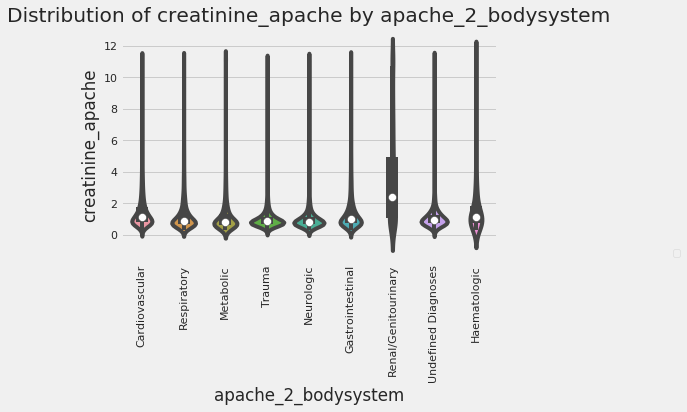

In [0]:
print("creatinine_apache missing: ", df.creatinine_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.creatinine_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="creatinine_apache", data=df)
plt.title("Distribution of creatinine_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### fio2_apache: check with two bodysystems
The fraction of inspired oxygen from the arterial blood gas taken during the first 24 hours of unit admission which produces the highest APACHE III score for oxygenation

fio2_apache missing:  70868
apache_3j_bodysystem missing:  1662
missing together:  1513
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

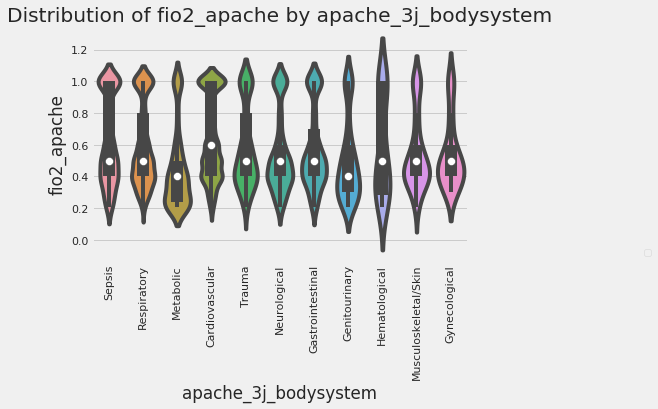

In [0]:
print("fio2_apache missing: ", df.fio2_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.fio2_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="fio2_apache", data=df)
plt.title("Distribution of fio2_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

fio2_apache missing:  70868
apache_2_bodysystem missing:  1662
missing together:  1513
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

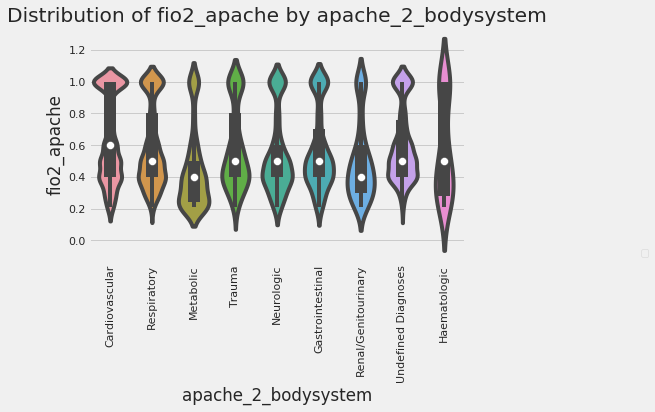

In [0]:
print("fio2_apache missing: ", df.fio2_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.fio2_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="fio2_apache", data=df)
plt.title("Distribution of fio2_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### gcs_eyes_apache: check with bodysystems

gcs_eyes_apache missing:  1901
apache_3j_bodysystem missing:  1662
missing together:  900
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

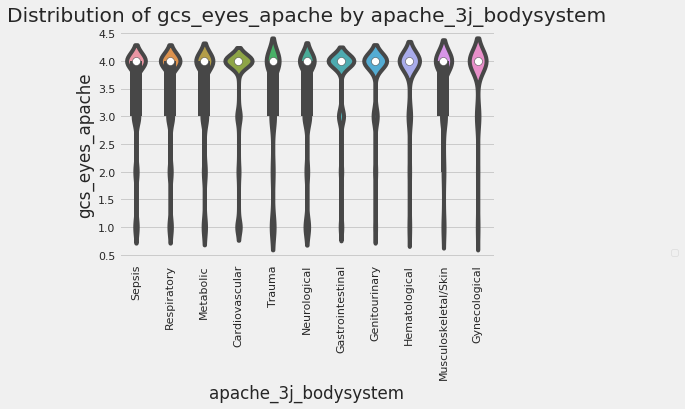

In [0]:
print("gcs_eyes_apache missing: ", df.gcs_eyes_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.gcs_eyes_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="gcs_eyes_apache", data=df)
plt.title("Distribution of gcs_eyes_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

gcs_eyes_apache missing:  1901
apache_2_bodysystem missing:  1662
missing together:  900
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

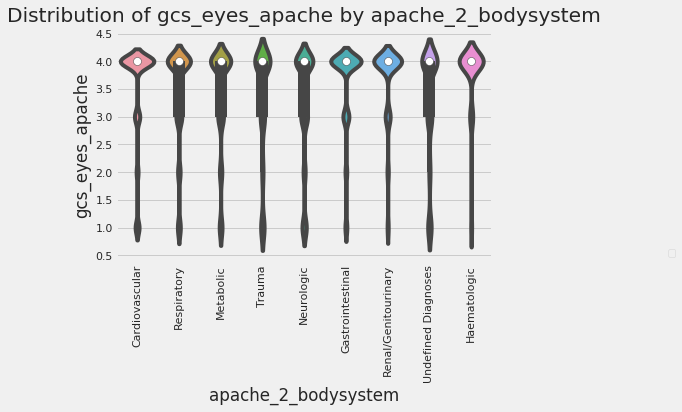

In [0]:
print("gcs_eyes_apache missing: ", df.gcs_eyes_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.gcs_eyes_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="gcs_eyes_apache", data=df)
plt.title("Distribution of gcs_eyes_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### gcs_motor_apache: check with two bodysystems

gcs_motor_apache missing:  1901
apache_3j_bodysystem missing:  1662
missing together:  900
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

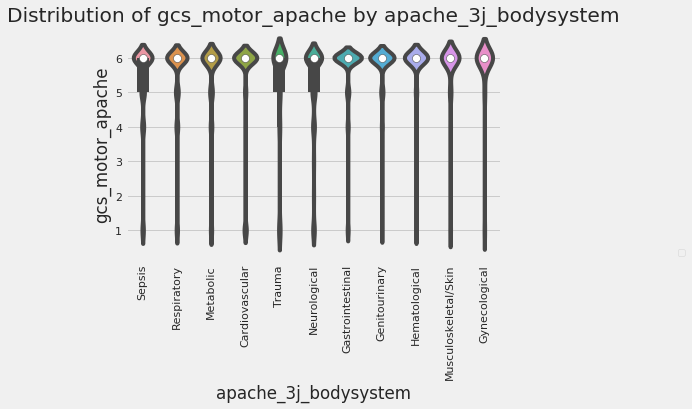

In [0]:
print("gcs_motor_apache missing: ", df.gcs_motor_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.gcs_motor_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="gcs_motor_apache", data=df)
plt.title("Distribution of gcs_motor_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

gcs_motor_apache missing:  1901
apache_2_bodysystem missing:  1662
missing together:  900
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

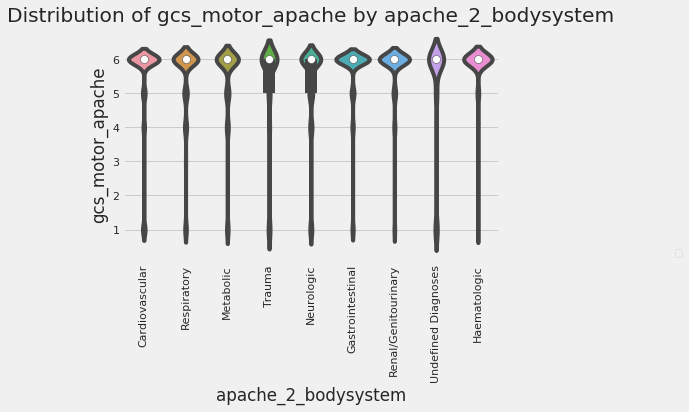

In [0]:
print("gcs_motor_apache missing: ", df.gcs_motor_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.gcs_motor_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="gcs_motor_apache", data=df)
plt.title("Distribution of gcs_motor_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### gcs_unable_apache: check with two bodysystems

In [0]:
from collections import Counter
Counter(df.gcs_unable_apache)

gcs_unable_apache missing:  1037
apache 3j bodysystem missing:  1662
missing together:  892
------------------------------------------------------------


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

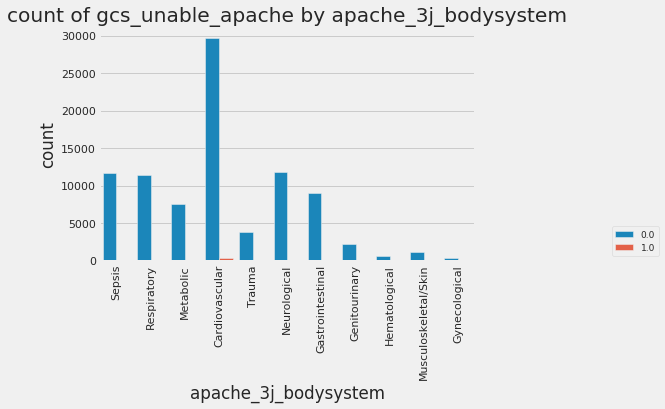

In [0]:
print("gcs_unable_apache missing: ", df.gcs_unable_apache.isnull().sum())
print("apache 3j bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.gcs_unable_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
#sns.barplot(x="apache_3j_bodysystem", hue="hospital_death", y="apache_3j_bodysystem",data=df)
sns.countplot(x="apache_3j_bodysystem", hue="gcs_unable_apache", data=df)
plt.title("count of gcs_unable_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

gcs_unable_apache missing:  1037
apache 2 bodysystem missing:  1662
missing together:  892
------------------------------------------------------------


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

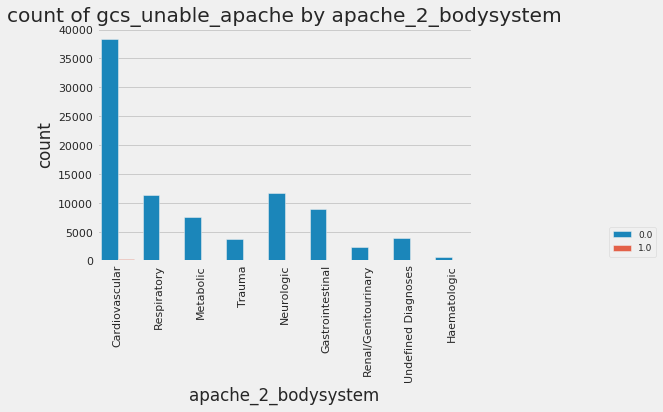

In [0]:
print("gcs_unable_apache missing: ", df.gcs_unable_apache.isnull().sum())
print("apache 2 bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.gcs_unable_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
#sns.barplot(x="apache_3j_bodysystem", hue="hospital_death", y="apache_3j_bodysystem",data=df)
sns.countplot(x="apache_2_bodysystem", hue="gcs_unable_apache", data=df)
plt.title("count of gcs_unable_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### gcs_verbal_apache: check with two bodysystems

gcs_verbal_apache missing:  1901
apache_3j_bodysystem missing:  1662
missing together:  900
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

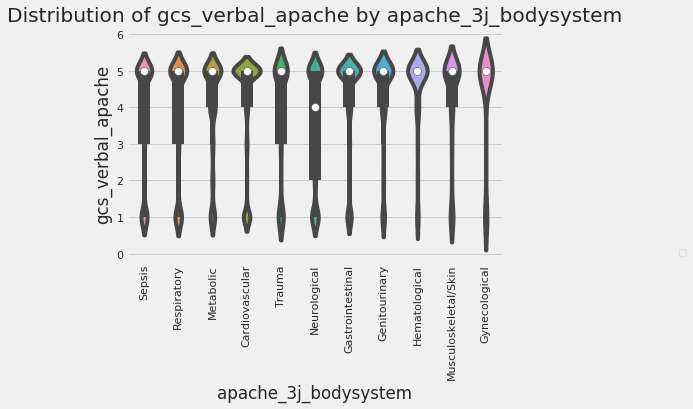

In [0]:
print("gcs_verbal_apache missing: ", df.gcs_verbal_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.gcs_verbal_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="gcs_verbal_apache", data=df)
plt.title("Distribution of gcs_verbal_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

gcs_verbal_apache missing:  1901
apache_2_bodysystem missing:  1662
missing together:  900
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

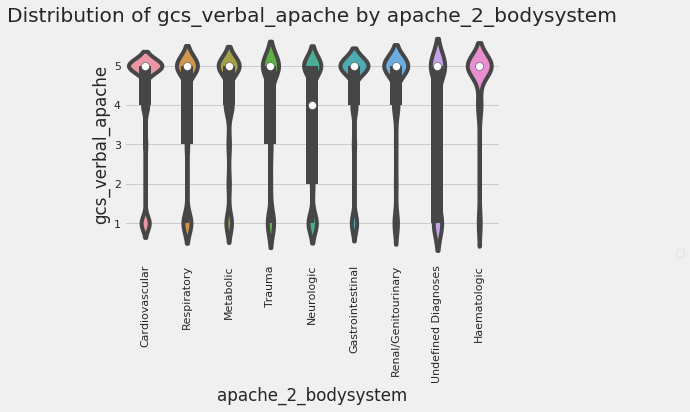

In [0]:
print("gcs_verbal_apache missing: ", df.gcs_verbal_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.gcs_verbal_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="gcs_verbal_apache", data=df)
plt.title("Distribution of gcs_verbal_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### glucose_apache: check with two bodysystems

glucose_apache missing:  11036
apache_3j_bodysystem missing:  1662
missing together:  940
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

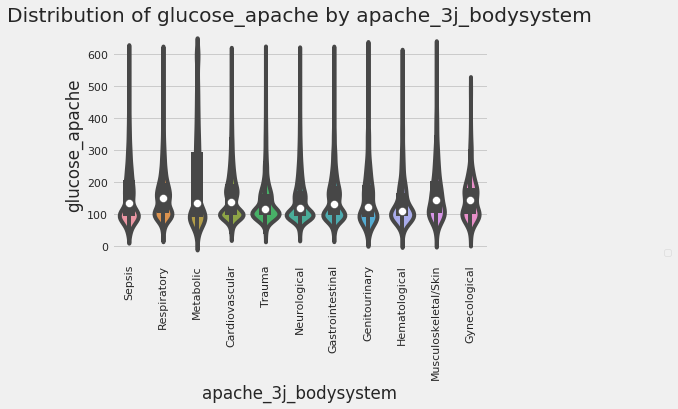

In [0]:
print("glucose_apache missing: ", df.glucose_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.glucose_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="glucose_apache", data=df)
plt.title("Distribution of glucose_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

glucose_apache missing:  11036
apache_2_bodysystem missing:  1662
missing together:  940
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

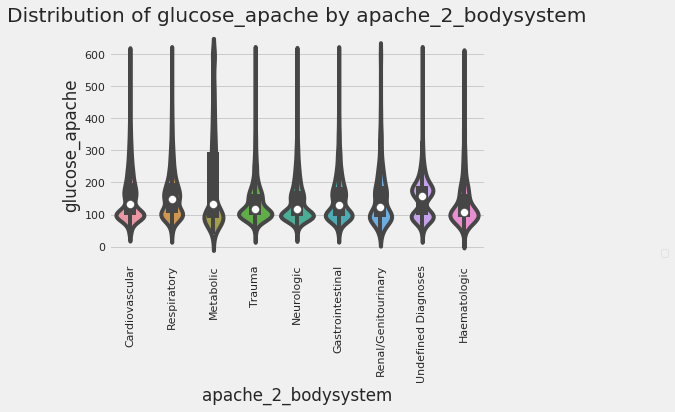

In [0]:
print("glucose_apache missing: ", df.glucose_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.glucose_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="glucose_apache", data=df)
plt.title("Distribution of glucose_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### heart_rate_apache

heart_rate_apache missing:  878
apache_3j_bodysystem missing:  1662
missing together:  778
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

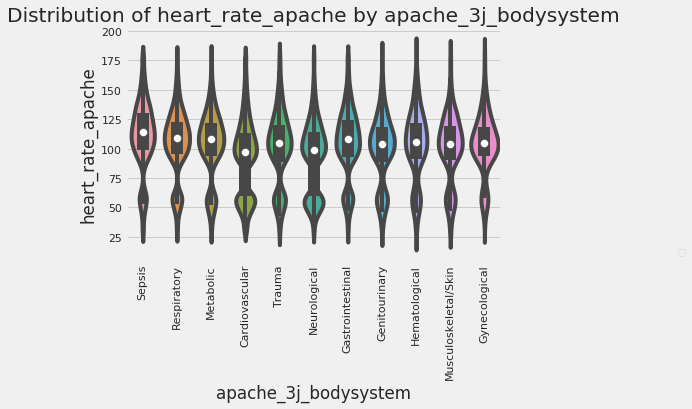

In [0]:
print("heart_rate_apache missing: ", df.heart_rate_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.heart_rate_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="heart_rate_apache", data=df)
plt.title("Distribution of heart_rate_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

heart_rate_apache missing:  878
apache_2_bodysystem missing:  1662
missing together:  778
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

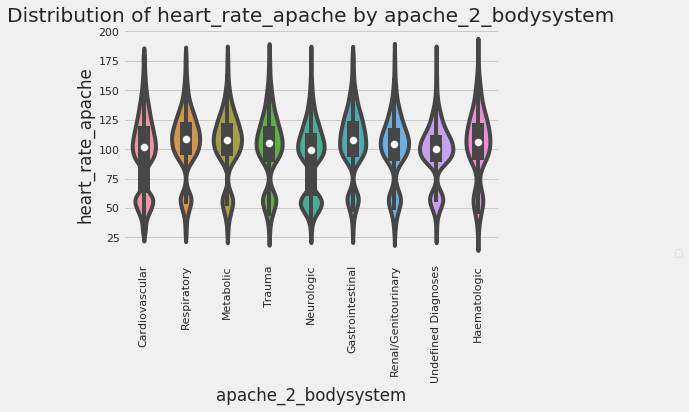

In [0]:
print("heart_rate_apache missing: ", df.heart_rate_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.heart_rate_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="heart_rate_apache", data=df)
plt.title("Distribution of heart_rate_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### hematocrit_apache

hematocrit_apache missing:  19878
apache_3j_bodysystem missing:  1662
missing together:  1019
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

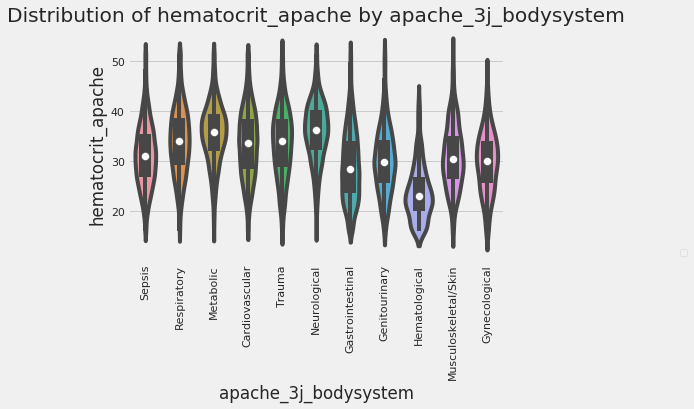

In [0]:
print("hematocrit_apache missing: ", df.hematocrit_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.hematocrit_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="hematocrit_apache", data=df)
plt.title("Distribution of hematocrit_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

hematocrit_apache missing:  19878
apache_2_bodysystem missing:  1662
missing together:  1019
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

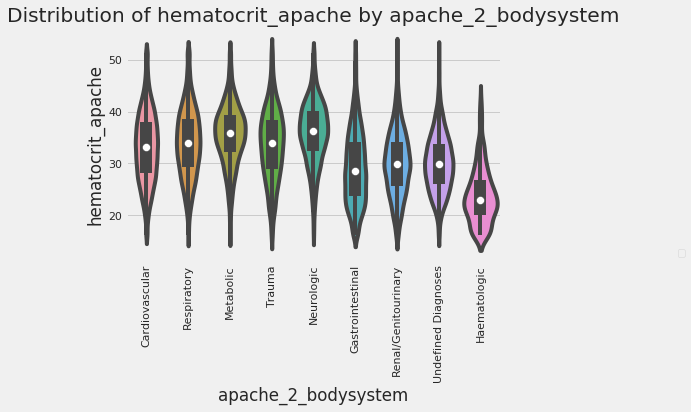

In [0]:
print("hematocrit_apache missing: ", df.hematocrit_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.hematocrit_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="hematocrit_apache", data=df)
plt.title("Distribution of hematocrit_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### intubated_apache

intubated_apache missing:  715
apache_3j_bodysystem missing:  1662
missing together:  715
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

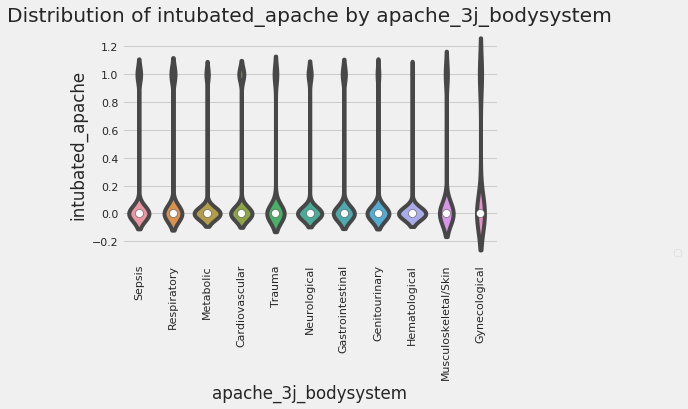

In [0]:
print("intubated_apache missing: ", df.intubated_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.intubated_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="intubated_apache", data=df)
plt.title("Distribution of intubated_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

intubated_apache missing:  715
apache_2_bodysystem missing:  1662
missing together:  715
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

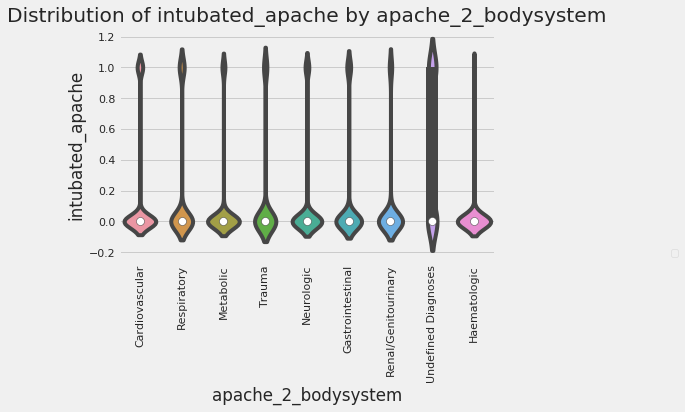

In [0]:
print("intubated_apache missing: ", df.intubated_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.intubated_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="intubated_apache", data=df)
plt.title("Distribution of intubated_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### map_apache

map_apache missing:  715
apache_3j_bodysystem missing:  1662
missing together:  789
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

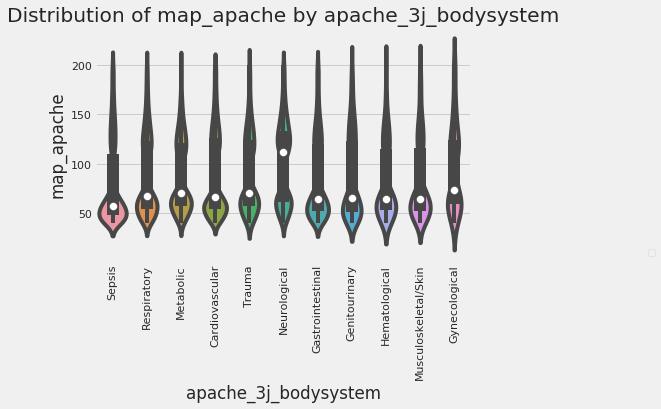

In [0]:
print("map_apache missing: ", df.intubated_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.map_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="map_apache", data=df)
plt.title("Distribution of map_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

map_apache missing:  994
apache_2_bodysystem missing:  1662
missing together:  789
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

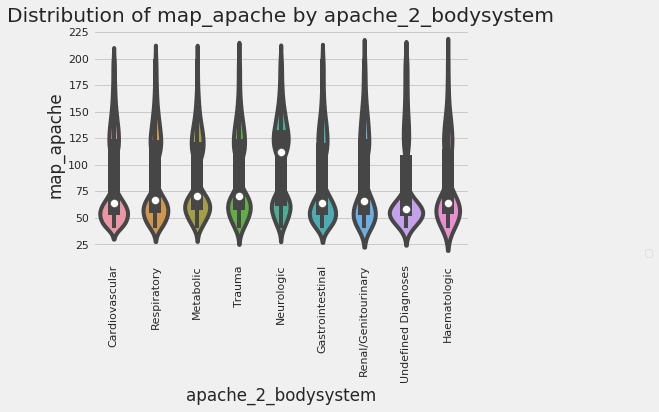

In [0]:
print("map_apache missing: ", df.map_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.map_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="map_apache", data=df)
plt.title("Distribution of map_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### paco2_apache

paco2_apache missing:  70868
apache_3j_bodysystem missing:  1662
missing together:  1513
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

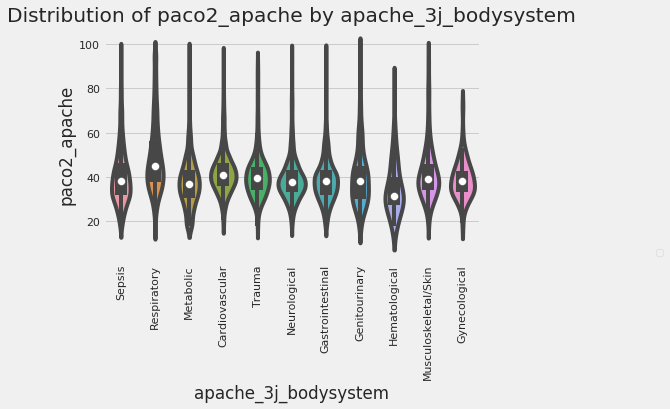

In [0]:
print("paco2_apache missing: ", df.paco2_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.paco2_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="paco2_apache", data=df)
plt.title("Distribution of paco2_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

paco2_apache missing:  70868
apache_2_bodysystem missing:  1662
missing together:  1513
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

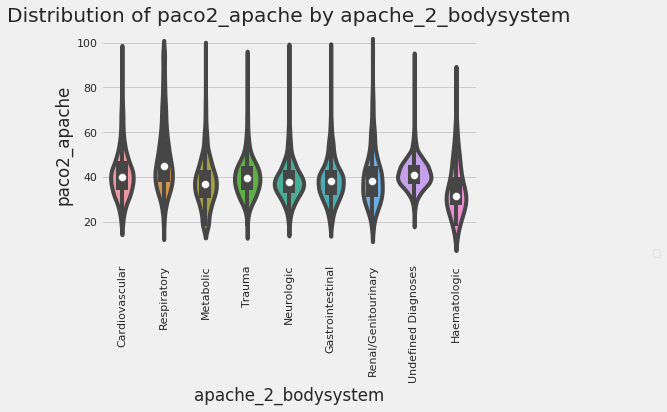

In [0]:
print("paco2_apache missing: ", df.paco2_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.paco2_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="paco2_apache", data=df)
plt.title("Distribution of paco2_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### paco2_for_ph_apache

paco2_for_ph_apache missing:  70868
apache_3j_bodysystem missing:  1662
missing together:  1513
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

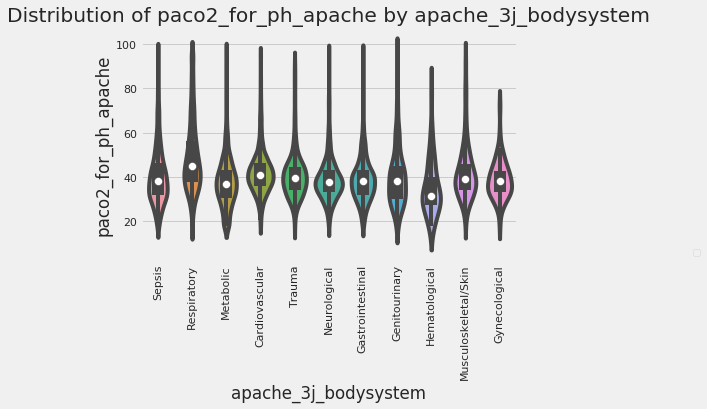

In [0]:
print("paco2_for_ph_apache missing: ", df.paco2_for_ph_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.paco2_for_ph_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="paco2_for_ph_apache", data=df)
plt.title("Distribution of paco2_for_ph_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

paco2_for_ph_apache missing:  70868
apache_2_bodysystem missing:  1662
missing together:  1513
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

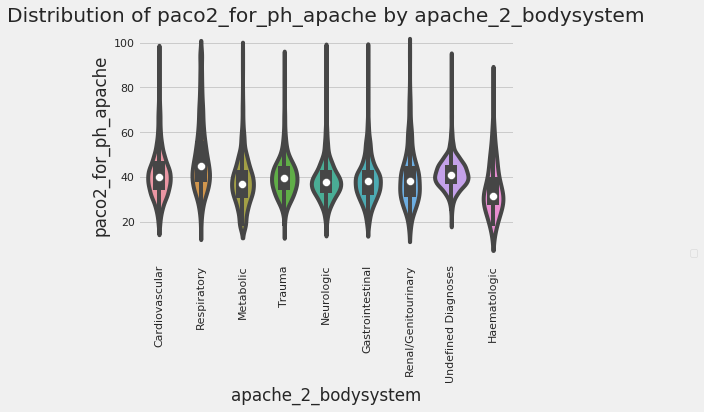

In [0]:
print("paco2_for_ph_apache missing: ", df.paco2_for_ph_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.paco2_for_ph_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="paco2_for_ph_apache", data=df)
plt.title("Distribution of paco2_for_ph_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### pao2_apache

pao2_apache missing:  70868
apache_3j_bodysystem missing:  1662
missing together:  1513
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

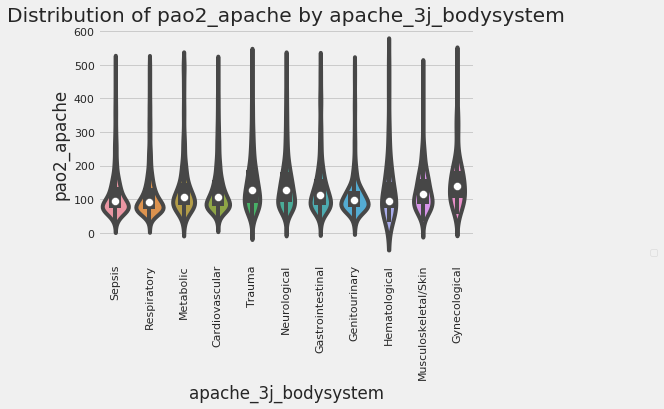

In [0]:
print("pao2_apache missing: ", df.pao2_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.pao2_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="pao2_apache", data=df)
plt.title("Distribution of pao2_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

pao2_apache missing:  70868
apache_2_bodysystem missing:  1662
missing together:  1513
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

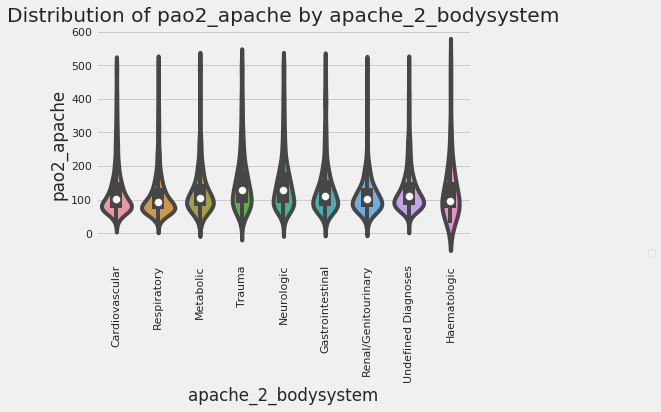

In [0]:
print("pao2_apache missing: ", df.pao2_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.pao2_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="pao2_apache", data=df)
plt.title("Distribution of pao2_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### ph_apache

ph_apache missing:  70868
apache_3j_bodysystem missing:  1662
missing together:  1513
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

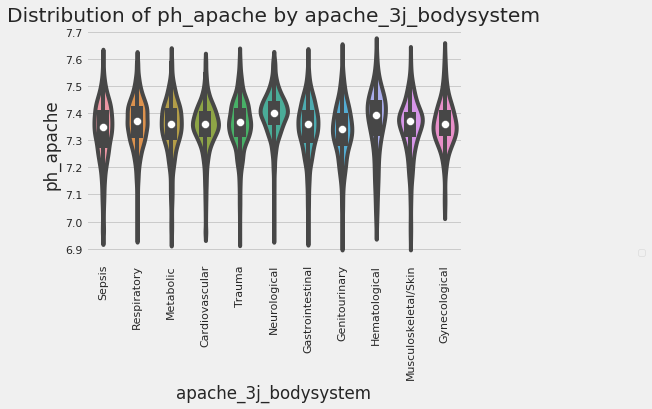

In [0]:
print("ph_apache missing: ", df.ph_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.ph_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="ph_apache", data=df)
plt.title("Distribution of ph_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

ph_apache missing:  70868
apache_2_bodysystem missing:  1662
missing together:  1513
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

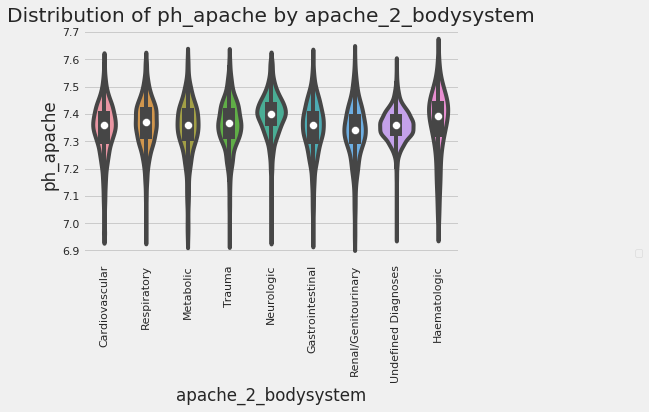

In [0]:
print("ph_apache missing: ", df.ph_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.ph_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="ph_apache", data=df)
plt.title("Distribution of ph_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### resprate_apache

resprate_apache missing:  1234
apache_3j_bodysystem missing:  1662
missing together:  776
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

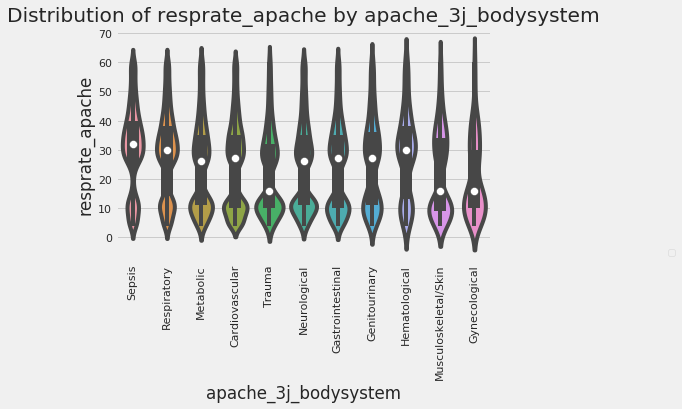

In [0]:
print("resprate_apache missing: ", df.resprate_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.resprate_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="resprate_apache", data=df)
plt.title("Distribution of resprate_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

resprate_apache missing:  1234
apache_2_bodysystem missing:  1662
missing together:  776
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

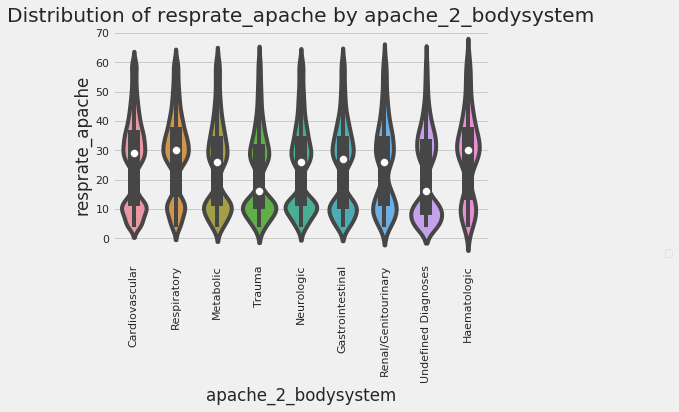

In [0]:
print("resprate_apache missing: ", df.resprate_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.resprate_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="resprate_apache", data=df)
plt.title("Distribution of resprate_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### sodium_apache

sodium_apache missing:  18600
apache_3j_bodysystem missing:  1662
missing together:  1040
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

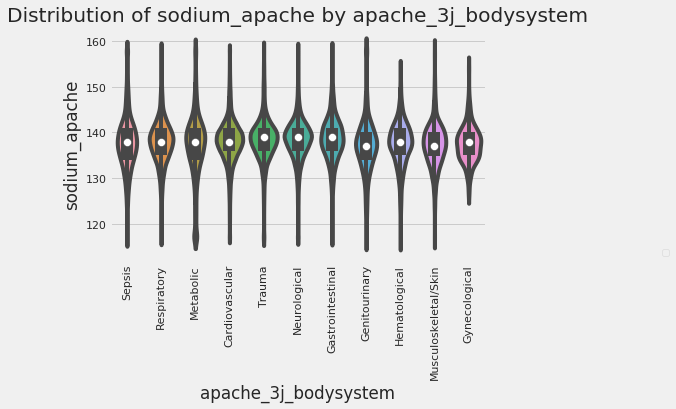

In [0]:
print("sodium_apache missing: ", df.sodium_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.sodium_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="sodium_apache", data=df)
plt.title("Distribution of sodium_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

sodium_apache missing:  18600
apache_2_bodysystem missing:  1662
missing together:  1040
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

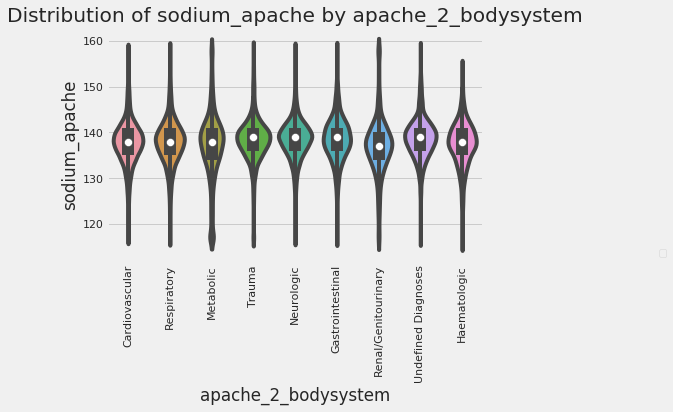

In [0]:
print("sodium_apache missing: ", df.sodium_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.sodium_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="sodium_apache", data=df)
plt.title("Distribution of sodium_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### temp_apache

temp_apache missing:  4108
apache_3j_bodysystem missing:  1662
missing together:  816
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

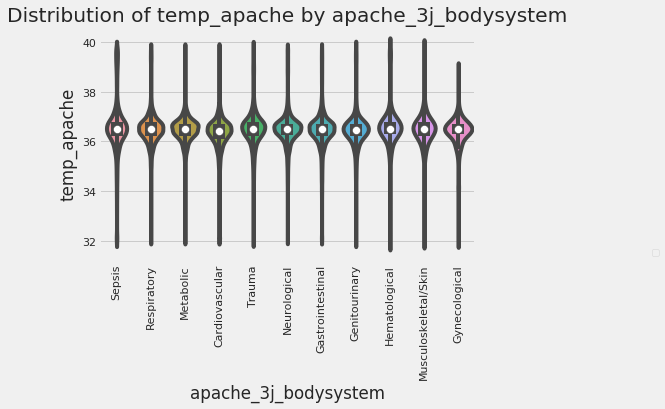

In [0]:
print("temp_apache missing: ", df.temp_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.temp_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="temp_apache", data=df)
plt.title("Distribution of temp_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

temp_apache missing:  4108
apache_2_bodysystem missing:  1662
missing together:  816
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

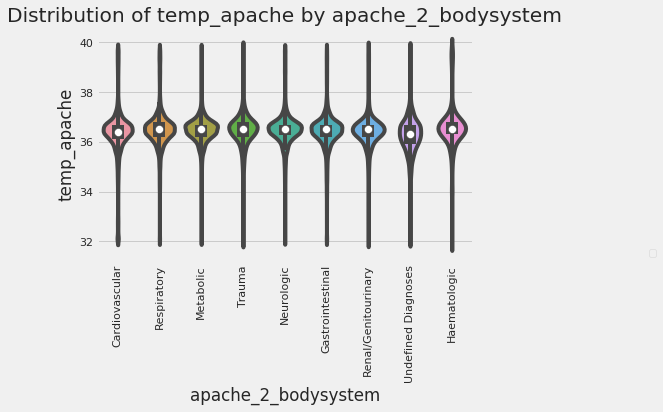

In [0]:
print("temp_apache missing: ", df.temp_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.temp_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="temp_apache", data=df)
plt.title("Distribution of temp_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### urineoutput_apache

urineoutput_apache missing:  48998
apache_3j_bodysystem missing:  1662
missing together:  1291
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

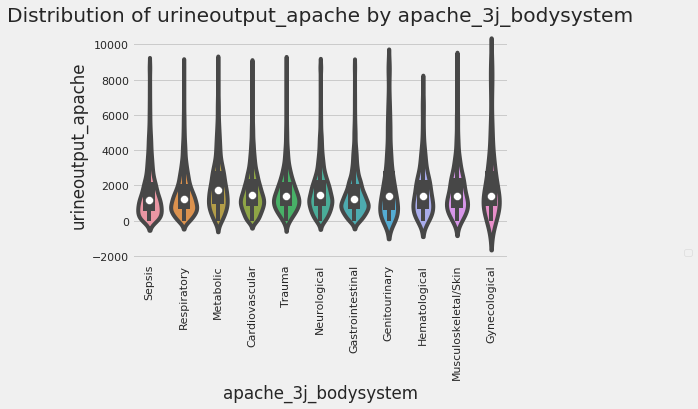

In [0]:
print("urineoutput_apache missing: ", df.urineoutput_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.urineoutput_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="urineoutput_apache", data=df)
plt.title("Distribution of urineoutput_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

urineoutput_apache missing:  48998
apache_2_bodysystem missing:  1662
missing together:  1291
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

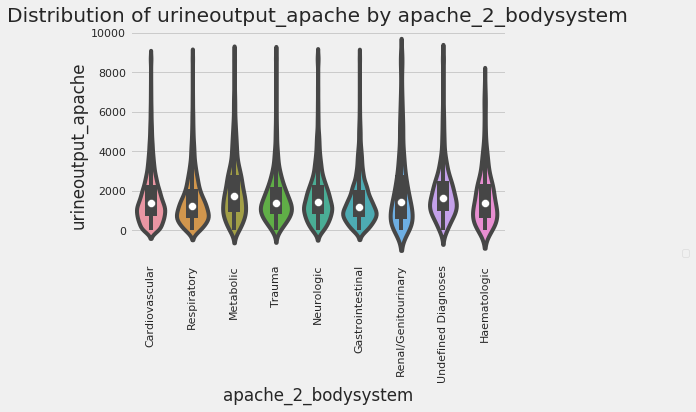

In [0]:
print("urineoutput_apache missing: ", df.urineoutput_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.urineoutput_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="urineoutput_apache", data=df)
plt.title("Distribution of urineoutput_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### ventilated_apache

ventilated_apache missing:  715
apache_3j_bodysystem missing:  1662
missing together:  715
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

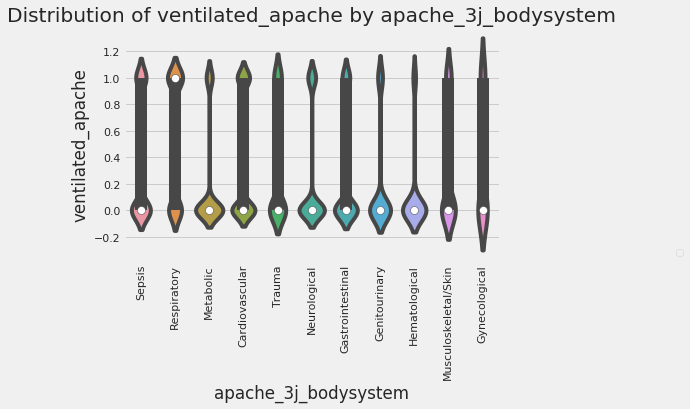

In [0]:
print("ventilated_apache missing: ", df.ventilated_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.ventilated_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="ventilated_apache", data=df)
plt.title("Distribution of ventilated_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

ventilated_apache missing:  715
apache_2_bodysystem missing:  1662
missing together:  715
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

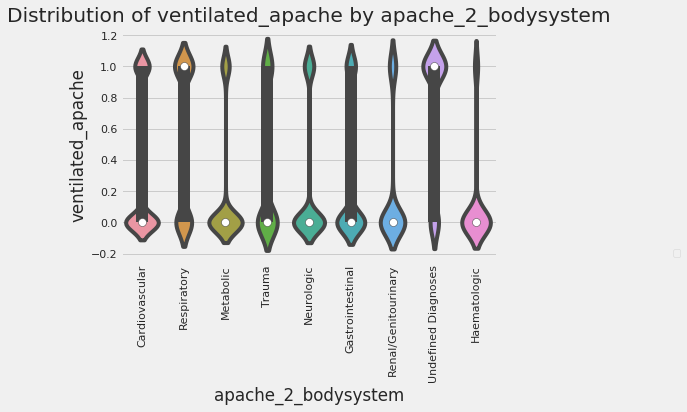

In [0]:
print("ventilated_apache missing: ", df.ventilated_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.ventilated_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="ventilated_apache", data=df)
plt.title("Distribution of ventilated_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

### wbc_apache
* wbc_apache: The white blood cell count measured during the first 24 hours which results in the highest APACHE III score

wbc_apache missing:  22012
apache_3j_bodysystem missing:  1662
missing together:  1047
------------------------------------------------------------


No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

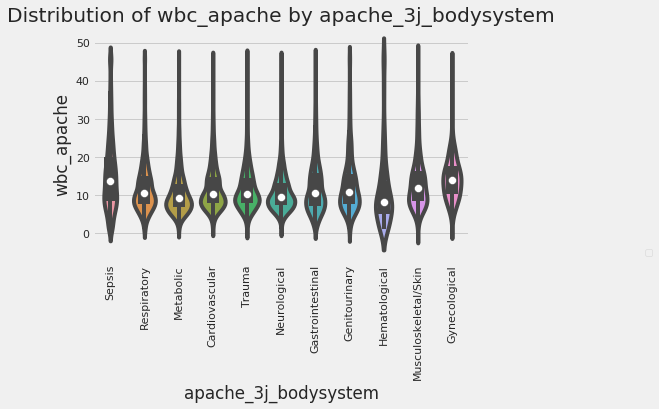

In [0]:
print("wbc_apache missing: ", df.wbc_apache.isnull().sum())
print("apache_3j_bodysystem missing: ", df.apache_3j_bodysystem.isnull().sum())
print("missing together: ", df[df.wbc_apache.isnull()].apache_3j_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_3j_bodysystem", y="wbc_apache", data=df)
plt.title("Distribution of wbc_apache by apache_3j_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

wbc_apache missing:  22012
apache_2_bodysystem missing:  1662
missing together:  1047
------------------------------------------------------------


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

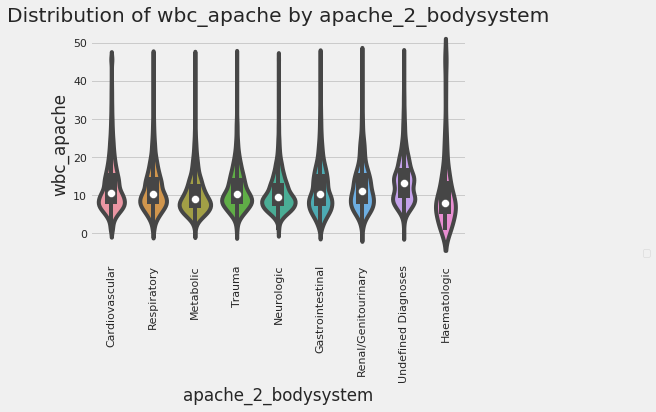

In [0]:
print("wbc_apache missing: ", df.wbc_apache.isnull().sum())
print("apache_2_bodysystem missing: ", df.apache_2_bodysystem.isnull().sum())
print("missing together: ", df[df.wbc_apache.isnull()].apache_2_bodysystem.isnull().sum())
print("-"*60)
sns.violinplot(x="apache_2_bodysystem", y="wbc_apache", data=df)
plt.title("Distribution of wbc_apache by apache_2_bodysystem")
plt.legend(bbox_to_anchor=(1.5, 0), loc='lower right', fontsize=9)
plt.xticks(rotation=90)

# Min Max Problem

In [0]:
[i for i in df.columns]

['Unnamed: 0',
 'encounter_id',
 'hospital_id',
 'patient_id',
 'hospital_death',
 'age',
 'bmi',
 'elective_surgery',
 'ethnicity',
 'gender',
 'height',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_id',
 'icu_stay_type',
 'icu_type',
 'pre_icu_los_days',
 'weight',
 'albumin_apache',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'apache_post_operative',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache',
 'd1_diasbp_invasive_max',
 'd1_diasbp_invasive_min',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd



 'd1_glucose_max',
 'd1_glucose_min',
 'd1_hco3_max',
 'd1_hco3_min',
 'd1_hemaglobin_max',
 'd1_hemaglobin_min',
 'd1_hematocrit_max',
 'd1_hematocrit_min',
 'd1_inr_max',
 'd1_inr_min',
 'd1_lactate_max',
 'd1_lactate_min',
 'd1_platelets_max',
 'd1_platelets_min',
 'd1_potassium_max',
 'd1_potassium_min',
 'd1_sodium_max',
 'd1_sodium_min',
 'd1_wbc_max',
 'd1_wbc_min',
 'd1_arterial_pco2_max',
 'd1_arterial_pco2_min',
 'd1_arterial_ph_max',
 'd1_arterial_ph_min',
 'd1_arterial_po2_max',
 'd1_arterial_po2_min',
 'd1_pao2fio2ratio_max',
 'd1_pao2fio2ratio_min'

In [0]:
#d1_diasbp_invasive_max', 'd1_diasbp_invasive_min
df[df['d1_diasbp_invasive_max']<df['d1_diasbp_invasive_min']]

Unnamed: 0  encounter_id  hospital_id  patient_id  hospital_death  age  bmi  elective_surgery      ethnicity gender  height hospital_admit_source           icu_admit_source  icu_id icu_stay_type      icu_type  pre_icu_los_days  weight  albumin_apache  apache_2_diagnosis  apache_3j_diagnosis  apache_post_operative  arf_apache  bilirubin_apache  bun_apache  creatinine_apache  fio2_apache  gcs_eyes_apache  gcs_motor_apache  gcs_unable_apache  gcs_verbal_apache  glucose_apache  heart_rate_apache  hematocrit_apache  intubated_apache  map_apache  paco2_apache  paco2_for_ph_apache  pao2_apache  ph_apache  resprate_apache  sodium_apache  temp_apache  urineoutput_apache  ventilated_apache  wbc_apache  d1_diasbp_invasive_max  d1_diasbp_invasive_min  d1_diasbp_max  d1_diasbp_min  d1_diasbp_noninvasive_max  d1_diasbp_noninvasive_min  d1_heartrate_max  d1_heartrate_min  d1_mbp_invasive_max  d1_mbp_invasive_min  d1_mbp_max  d1_mbp_min  d1_mbp_noninvasive_max  d1_mbp_noninvasive_min  \
49973  49973       19978         24           98880       0              72.0 29.8  1                 Other/Unknown  F     160.0    Floor                 Operating Room / Recovery  517     admit         CCU-CTICU    4.2               76.4    nan             202.0               1203.0                1                     0.0         nan               14.0        0.7                nan          4.0              6.0               0.0                5.0                165.0           123.0              26.3               0.0               179.0       nan           nan                  nan          nan        29.0             135.0          nan          4329.6              0.0                6.9         37.0                    43.0                    74.0           53.0           74.0                       53.0                       123.0             80.0              255.0                70.0                 106.0       74.0        106.0                   74.0                      
68413  68413       75349         139          39812       0              75.0 23.6  1                 Caucasian      F     167.6    Operating Room        Operating Room / Recovery  684     admit         Cardiac ICU  0.3               66.2    nan             202.0               1205.0                1                     0.0         nan               nan         nan                nan          4.0              6.0               0.0                5.0                115.0           104.0              nan                0.0               185.0       nan           nan                  nan          nan        43.0             nan            36.3         nan                 0.0                nan         37.0                    58.0                    67.0           63.0           67.0                       63.0                       81.0              67.0              185.0                88.0                 97.0        90.0        97.0                    90.0                      
81084  81084       123297        18           88247       0              42.0 30.2  1                 Caucasian      F     167.6    Direct Admit          Operating Room / Recovery  775     admit         Med-Surg ICU 0.3               84.8    nan             218.0               1505.0                1                     0.0         nan               10.0        0.7                nan          3.0              6.0               0.0                5.0                127.0           46.0               nan                0.0               199.0       nan           nan                  nan          nan        44.0             139.0          36.2         nan                 0.0                nan         37.0                    42.0                    81.0           42.0           81.0                       42.0                       98.0              46.0              199.0                57.0                 102.0       56.0        102.0                   56.0                      
89270  89270       48848         14

In [0]:
min_max_column =[('d1_diasbp_invasive_max','d1_diasbp_invasive_min'),
 ('d1_diasbp_max','d1_diasbp_min'),
 ('d1_diasbp_noninvasive_max','d1_diasbp_noninvasive_min'),
  ('d1_heartrate_max','d1_heartrate_min'),
 ('d1_mbp_invasive_max','d1_mbp_invasive_min'),
 ('d1_mbp_max','d1_mbp_min'),
 ('d1_mbp_noninvasive_max','d1_mbp_noninvasive_min'),
 ('d1_resprate_max','d1_resprate_min'),
 ('d1_spo2_max','d1_spo2_min'),
 ('d1_sysbp_invasive_max','d1_sysbp_invasive_min'),
 ('d1_sysbp_max','d1_sysbp_min'),
 ('d1_sysbp_noninvasive_max','d1_sysbp_noninvasive_min'),
 ('d1_temp_max','d1_temp_min'),
 ('d1_albumin_max','d1_albumin_min'),
 ('d1_bilirubin_max','d1_bilirubin_min'),
 ('d1_bun_max','d1_bun_min'),
 ('d1_calcium_max','d1_calcium_min'),
 ('d1_creatinine_max','d1_creatinine_min')]

In [0]:
df.shape

(91713, 122)

In [0]:
len(df['patient_id'].unique())

91713

In [0]:
from IPython.display import display
min_max_prob = []
for i in min_max_column:
  variables = i
  print(variables[0],variables[1])
  print(df[variables[0]].min(),df[variables[0]].max())
  print(df[variables[1]].min(),df[variables[1]].max())
  display(df.loc[df[variables[0]]<df[variables[1]],[variables[0],variables[1]]])
  min_max_prob +=df.loc[df[variables[0]]<df[variables[1]],'patient_id'].tolist()

d1_diasbp_invasive_max d1_diasbp_invasive_min
37.0 181.0
5.0 89.0


d1_diasbp_invasive_max  d1_diasbp_invasive_min
49973 37.0                    43.0                   
68413 37.0                    58.0                   
81084 37.0                    42.0                   
89270 37.0                    58.0

d1_diasbp_max d1_diasbp_min
46.0 165.0
13.0 90.0


d1_diasbp_max  d1_diasbp_min
32353 46.0           57.0          
35087 46.0           63.0          
37558 46.0           53.0          
43699 46.0           55.0          
48441 46.0           52.0          
55090 46.0           55.0          
55189 46.0           77.0          
56924 46.0           50.0          
61651 46.0           51.0          
61705 46.0           82.0          
84811 46.0           58.0          
84858 46.0           61.0          
87490 46.0           53.0          
89153 46.0           52.0

d1_diasbp_noninvasive_max d1_diasbp_noninvasive_min
46.0 165.0
13.0 90.0


d1_diasbp_noninvasive_max  d1_diasbp_noninvasive_min
32353 46.0                       57.0                      
35087 46.0                       63.0                      
43699 46.0                       55.0                      
48441 46.0                       52.0                      
55090 46.0                       55.0                      
55189 46.0                       77.0                      
56924 46.0                       50.0                      
61651 46.0                       51.0                      
61705 46.0                       82.0                      
84811 46.0                       58.0                      
84858 46.0                       61.0                      
87490 46.0                       53.0                      
89153 46.0                       52.0

d1_heartrate_max d1_heartrate_min
58.0 177.0
0.0 175.0


d1_heartrate_max  d1_heartrate_min
10857 58.0              80.0             
18989 58.0              68.0             
20228 58.0              60.0             
33490 58.0              64.0             
42163 58.0              62.0             
43422 58.0              90.0             
49407 58.0              76.0             
49813 58.0              105.0            
49838 58.0              114.0            
54399 58.0              62.0             
60072 58.0              93.0             
67505 58.0              73.0             
76679 58.0              102.0            
77824 58.0              86.0             
81955 58.0              109.0            
82258 58.0              73.0             
83861 58.0              64.0             
84915 58.0              96.0             
85122 58.0              89.0             
87283 58.0              129.0

d1_mbp_invasive_max d1_mbp_invasive_min
38.0 322.0
2.0 119.0


d1_mbp_invasive_max  d1_mbp_invasive_min
195   38.0                 66.0                
7543  38.0                 80.0                
24706 38.0                 62.0                
55103 38.0                 79.0                
58334 38.0                 39.0

d1_mbp_max d1_mbp_min
60.0 184.0
22.0 112.0


d1_mbp_max  d1_mbp_min
3422  60.0        103.0      
5068  60.0        72.0       
13489 60.0        73.0       
24570 60.0        85.0       
32110 60.0        68.0       
42734 60.0        67.0       
51564 60.0        85.0       
91601 60.0        69.0       
91689 60.0        77.0

d1_mbp_noninvasive_max d1_mbp_noninvasive_min
60.0 181.0
22.0 112.0


d1_mbp_noninvasive_max  d1_mbp_noninvasive_min
405   60.0                    86.0                   
3501  60.0                    92.0                   
5444  60.0                    70.0                   
5869  60.0                    82.0                   
11941 60.0                    89.0                   
12666 60.0                    95.0                   
24229 60.0                    69.0                   
32353 60.0                    63.0                   
33582 60.0                    102.0                  
33813 60.0                    75.0                   
39688 60.0                    75.0                   
45613 60.0                    82.0                   
48798 60.0                    76.0                   
59390 60.0                    81.0                   
66489 60.0                    62.0                   
71804 60.0                    80.0                   
89314 60.0                    62.0                   
89500 60.0                    64.0                   
89705 60.0                    89.0                   
91291 60.0                    79.0                   
91606 60.0                    62.0

d1_resprate_max d1_resprate_min
14.0 92.0
0.0 100.0


d1_resprate_max  d1_resprate_min
52067 14.0             20.0            
71776 92.0             96.0            
72737 14.0             25.0            
73863 92.0             100.0           
81314 14.0             18.0

d1_spo2_max d1_spo2_min
0.0 100.0
0.0 100.0


Empty DataFrame
Columns: [d1_spo2_max, d1_spo2_min]
Index: []

d1_sysbp_invasive_max d1_sysbp_invasive_min
71.0 295.0
10.0 172.0


d1_sysbp_invasive_max  d1_sysbp_invasive_min
32148 71.0                   104.0                 
39989 71.0                   79.0                  
50143 71.0                   104.0                 
53654 71.0                   96.0                  
69902 71.0                   123.0                 
88531 71.0                   136.0                 
89141 71.0                   93.0                  
89718 71.0                   93.0

d1_sysbp_max d1_sysbp_min
90.0 232.0
41.0 160.0


d1_sysbp_max  d1_sysbp_min
2384  90.0          100.0        
5979  90.0          100.0        
6237  90.0          101.0        
6250  90.0          148.0        
13742 90.0          109.0        
25136 90.0          157.0        
34785 90.0          91.0         
35341 90.0          94.0         
42859 90.0          96.0         
45393 90.0          105.0        
54832 90.0          131.0        
57128 90.0          93.0         
58163 90.0          130.0        
58857 90.0          104.0        
63537 90.0          111.0        
68352 90.0          153.0        
71588 90.0          160.0        
78429 90.0          109.0        
84076 90.0          148.0        
85199 90.0          108.0        
86107 90.0          112.0        
87129 90.0          119.0        
90573 90.0          108.0        
90955 90.0          118.0

d1_sysbp_noninvasive_max d1_sysbp_noninvasive_min
90.0 232.0
41.03 160.0


d1_sysbp_noninvasive_max  d1_sysbp_noninvasive_min
2384  90.0                      100.0                    
5979  90.0                      100.0                    
6237  90.0                      101.0                    
6250  90.0                      148.0                    
13742 90.0                      109.0                    
25136 90.0                      157.0                    
34785 90.0                      91.0                     
35341 90.0                      94.0                     
42859 90.0                      96.0                     
45393 90.0                      105.0                    
54832 90.0                      131.0                    
57128 90.0                      93.0                     
58163 90.0                      130.0                    
58857 90.0                      104.0                    
63537 90.0                      111.0                    
68352 90.0                      153.0                    
71588 90.0                      160.0                    
78429 90.0                      109.0                    
84076 90.0                      148.0                    
85199 90.0                      108.0                    
86107 90.0                      112.0                    
87129 90.0                      119.0                    
90955 90.0                      118.0

d1_temp_max d1_temp_min
35.1 39.9
31.889 37.8


d1_temp_max  d1_temp_min
346   35.1         36.8        
470   35.1         35.6        
1720  35.1         36.8        
5881  35.1         36.4        
8986  35.1         36.7        
9134  35.1         37.2        
9291  35.1         36.8        
9870  35.1         37.2        
12360 35.1         36.6        
14190 35.1         35.4        
17097 35.1         36.0        
17738 35.1         37.0        
17903 35.1         36.7        
19524 35.1         36.8        
26096 35.1         37.8        
27044 35.1         37.4        
29215 35.1         37.4        
29496 35.1         36.5        
29658 35.1         36.8        
31875 35.1         36.0        
38622 35.1         36.4        
39602 35.1         36.6        
40225 35.1         37.2        
41241 35.1         36.3        
41592 35.1         36.8        
42280 35.1         36.7        
42496 35.1         36.8        
42621 35.1         36.9        
42764 35.1         36.1        
43454 35.1         37.4        
43494 35.1         37.6        
43711 35.1         36.0        
43933 35.1         37.0        
44224 35.1         36.1        
44972 35.1         37.2        
46098 35.1         37.1        
46099 35.1         36.5        
46809 35.1         36.5        
47108 35.1         37.1        
48421 35.1         37.2        
50567 35.1         37.8        
51403 35.1         37.4        
53989 35.1         36.8        
54932 35.1         37.8        
56244 35.1         37.8        
56269 35.1         37.8        
64735 35.1         36.8        
65067 35.1         36.0        
66444 35.1         36.5        
70396 35.1         37.8        
75192 35.1         37.2        
82260 35.1         36.4        
82374 35.1         35.9        
83043 35.1         35.7        
84485 35.1         36.9        
86179 35.1         36.1        
87960 35.1         37.0        
88219 35.1         37.1        
89399 35.1         37.0        
89697 35.1         37.4        
89937 35.1         37.2

d1_albumin_max d1_albumin_min
1.2 4.6
1.1 4.5


d1_albumin_max  d1_albumin_min
1501  1.2             3.8            
9178  1.2             4.5            
10090 1.2             4.5            
10219 1.2             4.5            
10330 1.2             4.5            
10376 1.2             4.5            
10471 1.2             4.5            
11044 1.2             4.5            
11352 1.2             4.5            
11753 1.2             4.5            
12548 1.2             4.5            
12679 1.2             4.5            
14166 1.2             4.5            
14168 1.2             4.5            
14345 1.2             4.5            
15301 1.2             4.5            
18304 1.2             4.5            
20023 1.2             4.5            
21635 1.2             4.5            
25090 1.2             4.5            
25490 1.2             4.5            
26492 1.2             4.2            
30897 1.2             4.5            
31119 1.2             3.2            
35710 1.2             2.8            
38760 1.2             4.3            
42530 1.2             4.5            
42532 1.2             4.5            
42949 1.2             3.9            
44882 1.2             4.5            
44983 1.2             4.5            
45330 1.2             4.5            
52610 1.2             3.8            
57035 1.2             4.5            
57274 1.2             3.6            
57754 1.2             4.5            
58238 1.2             4.5            
59046 1.2             4.5            
59064 1.2             4.5            
60489 1.2             4.5            
61251 1.2             4.5            
61277 1.2             4.5            
61862 1.2             3.6            
62727 1.2             4.2            
63329 1.2             4.5            
64289 1.2             4.5            
64302 1.2             4.3            
65088 1.2             4.5            
66576 1.2             4.5            
67557 1.2             4.5            
67666 1.2             4.5            
67830 1.2             3.3            
67999 1.2             3.7            
68536 1.2             4.5            
68778 1.2             4.4            
69145 1.2             4.5            
69327 1.2             4.5            
71295 1.2             4.4            
71566 1.2             4.2            
71898 1.2             4.5            
72790 1.2             4.2            
73147 1.2             4.0            
74083 1.2             4.5            
75431 1.2             4.5            
75470 1.2             4.5            
75616 1.2             4.5            
76640 1.2             4.5            
76777 1.2             4.5            
77266 1.2             4.5            
79188 1.2             4.5            
79228 1.2             4.5            
79333 1.2             4.2            
80889 1.2             4.5            
82821 1.2             4.5            
84047 1.2             4.5            
86228 1.2             4.5            
89245 1.2             4.5            
90396 1.2             4.5            
90771 1.2             3.1            
90930 1.2             4.5            
91146 1.2             2.6            
91154 1.2             3.7            
91262 1.2             3.6            
91409 1.2             3.0            
91680 1.2             4.5

d1_bilirubin_max d1_bilirubin_min
0.2 51.0
0.2 51.0


Empty DataFrame
Columns: [d1_bilirubin_max, d1_bilirubin_min]
Index: []

d1_bun_max d1_bun_min
4.0 126.0
3.0 113.09


d1_bun_max  d1_bun_min
5678  4.0         113.1      
13466 4.0         113.1      
17084 4.0         53.0       
19002 4.0         76.0       
23600 4.0         113.1      
27544 4.0         83.0       
31353 4.0         113.1      
32944 4.0         113.1      
41326 4.0         113.1      
42972 4.0         88.0       
51509 4.0         113.1      
53224 4.0         101.0      
53932 4.0         58.0       
54053 4.0         113.1      
54960 4.0         107.0      
65094 4.0         113.0      
66684 4.0         109.0      
70675 4.0         100.0      
72434 4.0         75.0       
74349 4.0         113.1      
80128 4.0         113.1

d1_calcium_max d1_calcium_min
6.2 10.8
5.5 10.3


d1_calcium_max  d1_calcium_min
157   6.2             10.3           
2555  6.2             10.3           
6132  6.2             10.3           
10632 6.2             9.4            
22075 6.2             8.9            
25391 6.2             7.9            
38118 6.2             10.3           
39180 6.2             7.2            
40602 6.2             9.8            
41947 6.2             10.3           
42562 6.2             10.3           
43468 6.2             10.3           
43938 6.2             10.3           
44164 6.2             10.3           
46549 6.2             8.5            
47388 6.2             10.3           
52428 6.2             10.3           
55814 6.2             10.3           
56248 6.2             9.7            
56529 6.2             9.6            
57250 6.2             9.8            
60281 6.2             8.2            
61277 6.2             10.3           
63886 6.2             10.2           
65821 6.2             10.3           
67347 6.2             10.3           
69817 6.2             9.6            
70186 6.2             10.3           
70526 6.2             10.3           
73822 6.2             10.3           
74049 6.2             8.5            
75658 6.2             10.0           
76108 6.2             10.3           
79839 6.2             8.0            
82835 6.2             8.7            
90506 6.2             10.3           
90701 6.2             8.4            
91199 6.2             9.9            
91343 6.2             8.9

d1_creatinine_max d1_creatinine_min
0.34 11.11
0.3 9.9379


d1_creatinine_max  d1_creatinine_min
40468 0.3                9.9

In [0]:
df.loc[df['d1_diasbp_max']<df['d1_diasbp_min'],['d1_diasbp_max','d1_diasbp_min','d1_diasbp_noninvasive_max','d1_diasbp_noninvasive_min']]

d1_diasbp_max  d1_diasbp_min  d1_diasbp_noninvasive_max  d1_diasbp_noninvasive_min
32353 46.0           57.0           46.0                       57.0                      
35087 46.0           63.0           46.0                       63.0                      
37558 46.0           53.0           nan                        nan                       
43699 46.0           55.0           46.0                       55.0                      
48441 46.0           52.0           46.0                       52.0                      
55090 46.0           55.0           46.0                       55.0                      
55189 46.0           77.0           46.0                       77.0                      
56924 46.0           50.0           46.0                       50.0                      
61651 46.0           51.0           46.0                       51.0                      
61705 46.0           82.0           46.0                       82.0                      
84811 46.0           58.0           46.0                       58.0                      
84858 46.0           61.0           46.0                       61.0                      
87490 46.0           53.0           46.0                       53.0                      
89153 46.0           52.0           46.0                       52.0

In [0]:
#all data elements that has min max problem
df[df['patient_id'].isin(np.unique(min_max_prob))]

Unnamed: 0  encounter_id  hospital_id  patient_id  hospital_death  age  bmi  elective_surgery         ethnicity gender  height hospital_admit_source           icu_admit_source  icu_id icu_stay_type      icu_type  pre_icu_los_days  weight  albumin_apache  apache_2_diagnosis  apache_3j_diagnosis  apache_post_operative  arf_apache  bilirubin_apache  bun_apache  creatinine_apache  fio2_apache  gcs_eyes_apache  gcs_motor_apache  gcs_unable_apache  gcs_verbal_apache  glucose_apache  heart_rate_apache  hematocrit_apache  intubated_apache  map_apache  paco2_apache  paco2_for_ph_apache  pao2_apache  ph_apache  resprate_apache  sodium_apache  temp_apache  urineoutput_apache  ventilated_apache  wbc_apache  d1_diasbp_invasive_max  d1_diasbp_invasive_min  d1_diasbp_max  d1_diasbp_min  d1_diasbp_noninvasive_max  d1_diasbp_noninvasive_min  d1_heartrate_max  d1_heartrate_min  d1_mbp_invasive_max  d1_mbp_invasive_min  d1_mbp_max  d1_mbp_min  d1_mbp_noninvasive_max  d1_mbp_noninvasive_min  \
157    157         99236         118          13214       0              75.0 24.8  0                 Caucasian         F     162.6    Floor                 Floor                      93      admit         Med-Surg ICU 6.2               65.7    nan             303.0               211.1                 0                     0.0         nan               5.0         0.6                0.4          4.0              6.0               0.0                5.0                131.0           144.0              35.6               0.0               131.0       45.0          45.0                 74.0         7.5        59.0             144.0          37.2         nan                 0.0                12.7        nan                     nan                     101.0          46.0           101.0                      46.0                       144.0             70.0              nan                  nan                  131.0       71.0        131.0                   71.0                      
195    195         17645         149          44964       0              71.0 nan   1                 Caucasian         M     172.7    Operating Room        Operating Room / Recovery  103     admit         SICU         0.0               nan     nan             209.0               1302.0                1                     0.0         nan               18.0        1.3                nan          4.0              6.0               0.0                5.0                251.0           62.0               37.8               0.0               194.0       nan           nan                  nan          nan        33.0             138.0          36.7         nan                 0.0                11.9        95.0                    34.0                    84.0           55.0           84.0                       55.0                       85.0              57.0              38.0                 66.0                 126.0       79.0        126.0                   79.0                      
346    346         3479          81           18340       0              87.0 23.3  0                 Caucasian         M     172.7    Floor                 Floor                      90      admit         Med-Surg ICU 0.2               69.5    nan             113.0               501.1                 0                     0.0         nan               nan         1.3                nan          4.0              6.0               0.0                4.0                nan             120.0              45.6               0.0               122.0       nan           nan                  nan          nan        41.0             nan            39.7         nan                 0.0                12.0        nan                     nan                     95.0           51.0           95.0                       51.0                       107.0             68.0              nan                  nan                  122.0       69.0        122.0                   69.0                      
405    405         1232

In [0]:
len(np.unique(min_max_prob))

315

In [0]:
dictionary

Category                  Variable Name         Unit of Measure Data Type                                                                                                                                                                                                                                                                                                              Description           Example
0    identifier                 encounter_id                   None                    integer   Unique identifier associated with a patient unit stay                                                                                                                                                                                                                                                                    None            
1    identifier                 hospital_id                    None                    integer   Unique identifier associated with a hospital                                                                                                                                                                                                                                                                             None            
2    identifier                 patient_id                     None                    integer   Unique identifier associated with a patient                                                                                                                                                                                                                                                                              None            
3    demographic                hospital_death                 None                    binary    Whether the patient died during this hospitalization                                                                                                                                                                                                                                                                     0               
4    demographic                age                            Years                   numeric   The age of the patient on unit admission                                                                                                                                                                                                                                                                                 None            
5    demographic                bmi                            kilograms/metres^2      string    The body mass index of the person on unit admission                                                                                                                                                                                                                                                                      21.5            
6    demographic                elective_surgery               None                    binary    Whether the patient was admitted to the hospital for an elective surgical operation                                                                                                                                                                                                                                      0               
7    demographic                ethnicity                      None                    string    The common national or cultural tradition which the person belongs to                                                                                                                                                                                                                                                    Caucasian       
8    demographic                gender                         None                    string    The genotypical sex of the patient                                                